In [87]:
%load_ext autoreload
%autoreload 2
#This code is for a SSH 1D CROW network.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from scipy.fft import fft, ifft, fftfreq
from matplotlib.pyplot import figure
import math as m
from segment import Segment
from func import *
import matplotlib.ticker as ticker

In [89]:
# NUM_PORTS = 4
SIZE = 100
imp0 = 377
xs0 = 50  # source position for the segment 0
# kappa = 1j*0.15 #alternate couplings for SSH lattice
tau = 0.7
# tau = 1j* np.sqrt(1-np.abs(kappa)**2) # not working yet for complex number
# print(kappa)
maxTime = 20000

rings_no = 3   #out of N rings defined, 2 will be the input and output port (the first segment will have the source as the only connection; the last segment is redundant, the second last segment will act as the drop port.)
N_seg = rings_no*2

sources = Sources(rings_no)  #working for any number of rings
couplings = Couplings(rings_no, tau)

print(sources)
print(couplings)

ez_tab = np.zeros([N_seg, maxTime, SIZE], dtype=complex)

[[-1 -1]
 [ 0  3]
 [ 3  0]
 [ 2  5]
 [ 5  2]
 [-2 -2]]
[[0.7+0.j         0. +0.71414284j]
 [0.7+0.j         0. +0.71414284j]
 [0.7+0.j         0. +0.71414284j]
 [0.7+0.j         0. +0.71414284j]
 [0.7+0.j         0. +0.71414284j]
 [0.7+0.j         0. +0.71414284j]]


In [90]:
points_per_lambda = 50
c = 2.99792e8 #m/s
f0= 200e12 #200 THz
# lambda0 = 500e-9 #500nm in the optical range
lambda0 = c/f0 #carrier frequency (resoanant frequency)
print(lambda0 * 1e9) #~1498 nm in the optical range(used in applications)
del_x = lambda0/points_per_lambda #spatial step (want 20 grid points per wavelength)
S = 0.99 #Courant number
del_t = (S * del_x)/c

N_space = SIZE #spatial domain length
L = del_x * (N_space - 1) #total spatial length 

N_time = maxTime #temporal domain length
T_total = N_time * del_t #total simulated time

N_cycle = T_total * f0 #total number of cycles

Nyq = 1/(2*f0) #Nyquist number (del_t must be smaller than this for proper sampling)

if del_t < Nyq:
    print("Possible")
    s2 = []
    for qTime in range(maxTime):
        signal = cw2(qTime, del_t, f0)
        s2.append(signal)
        
print(del_t)
print(f0*1e-12) #in THz

1498.9599999999998
Possible
9.9e-17
200.0


c:\Users\Mitali\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Mitali\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


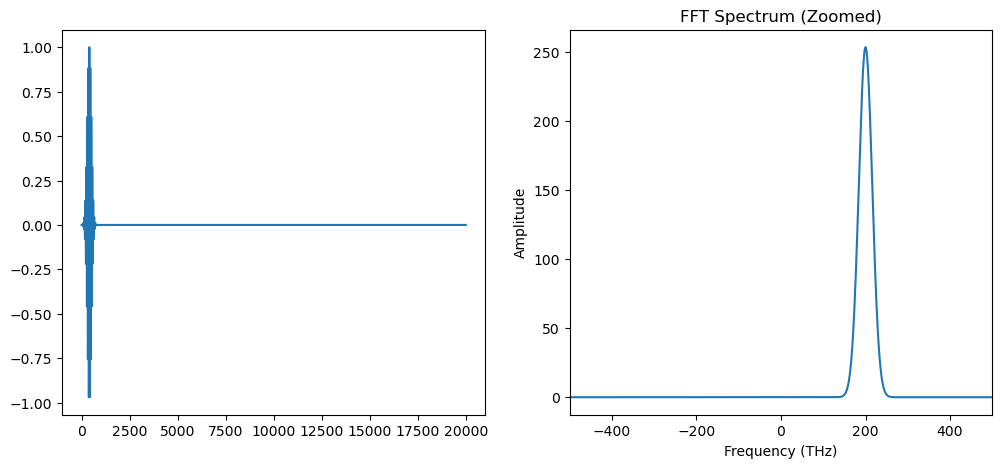

In [91]:
s3 = []
for qTime in range(maxTime):
    d = cosMod(qTime=qTime, complex_signal=True, f0=f0, del_t=del_t)
    s3.append(d)

s3 = np.array(s3)

# FFT
fft_vals = np.fft.fft(s3)
N = len(s3)
freqs = np.fft.fftfreq(N, del_t)

# Shift for visualization
fft_shift = np.abs(np.fft.fftshift(fft_vals))
freqs_shift = np.fft.fftshift(freqs)

# Plot

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot((s3))
plt.subplot(1,2,2)
plt.plot(freqs_shift/1e12, np.abs(fft_shift))
plt.xlabel("Frequency (THz)")
plt.ylabel("Amplitude")
plt.title("FFT Spectrum (Zoomed)")
plt.xlim(-500, 500)   # zoom to ±500 THz
plt.show()


In [92]:
#Printing input signals
# gauss = []
# cont = []
# print(range(maxTime))

# for qTime in range(maxTime):
#     g = gaussian(qTime, maxTime)
#     print(g)
#     conti = cw(qTime)
#     gauss.append(g)
#     cont.append(conti)
# print(np.shape(gauss))
# print(gauss)


# if del_t < Nyq:
#     print("Possible")
#     s2 = []
#     for qTime in range(maxTime):
#         signal = cw2(qTime, del_t, f0)
#         s2.append(signal)
#     figure(figsize=(20,10), dpi=80)
#     plt.subplot(1,2,1)
#     plt.plot(s2)

# fft_vals = np.abs(np.fft.fft(gauss))
# N = len(gauss)
# freqs = np.fft.fftfreq(N, d = del_t)
# plt.subplot(1,2,1)
# plt.plot(gauss)
# plt.subplot(1,2,2)
# plt.plot(freqs, np.abs(fft_vals))

# plt.show()
# plt.subplot(2,1,2)

# plt.plot(cont)
# plt.show()




In [93]:
f_array = []

s_tab = np.zeros(maxTime, dtype=complex)

for ii in range(N_seg):
    f = Segment(SIZE)
    f_array.append(f)
# print(f_array)

# lambda0 = 500e-9 
# f_center = 3e8/lambda0
# sigma_pulse = 3e-15 

# print("freq. Hz", f_center) 


for qTime in range(maxTime):
    s = cosMod(qTime, complex_signal=True, f0=f0, del_t=del_t) 
    s_tab[qTime] = s
    
    for ii in range(N_seg):
        s1 = sources[ii][0]
        s2 = sources[ii][1]
        tau_ = couplings[ii][0]
        kappa_ = couplings[ii][1]
        
        xs = xs0
        if (sources[ii][0] == -1):
            s_new = s   
            xs = xs0
        elif (sources[ii][0] == -2):
            s_new = 0. 
        else:
            s_new = tau_*f_array[s1].ez[-1] + kappa_*f_array[s2].ez[-1]
            xs = 2  
            
        # print(s_new)
        
        f_array[ii].hy_update()
        f_array[ii].hy_sources(s_new,xs)
        f_array[ii].ez_update()
        f_array[ii].ez_sources(s_new,xs)
        

        ez_tab[ii,qTime,:] = f_array[ii].ez[:]   

for ii in range(N_seg):
    filename = f"data/ez_tab_ssh{ii:04d}.csv"  # e.g., ez_tab_0000.txt, ez_tab_0001.txt, ...
    np.savetxt(filename, ez_tab[ii, :, :], delimiter=",")

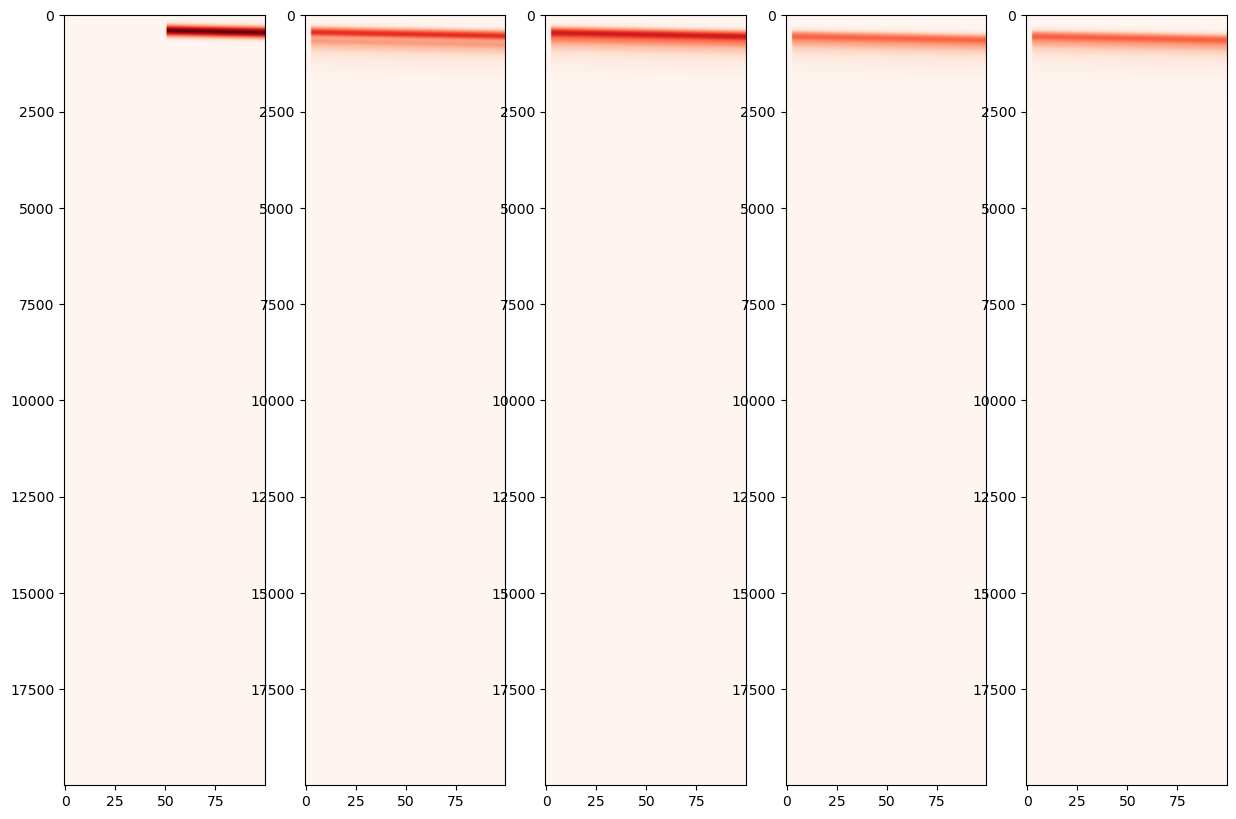

In [94]:
f, ax = plt.subplots(1,N_seg-1, figsize=(15,10)) 

vmax_val = np.max(np.real(ez_tab[0,:,:]))

for ii in range(N_seg-1):
    ax[ii].imshow(np.abs(ez_tab[ii,:,:]), aspect='auto', vmin = 0, vmax = vmax_val , cmap = 'Reds')

In [ ]:

Ez = np.zeros((maxTime-1,N_seg), dtype=complex)
# yf = np.zeros((maxTime-1,N_seg), dtype=complex)
windowed_signal = np.zeros((maxTime-1,N_seg), dtype=complex)
spectrum = np.zeros((maxTime-1, N_seg), dtype=complex)

print(len(freqs))
for ii in range(N_seg):
    filename = f"data/ez_tab_ssh{ii:04d}.csv"
    df = pd.read_csv(filename)
    # print(df.shape)
    Ez[:,ii] = df.iloc[:,60]   #all rows of the 10th spatial point
    
    Ez[:,ii] -= np.mean(Ez[:,ii])
    
    spectrum[:,ii] = np.fft.fft(Ez[:,ii])
N = len(Ez[:,0])
freqs = np.fft.fftfreq(N, del_t)
mask = freqs >= 0
freqs = freqs[mask]
spectrum = np.abs(spectrum[mask,:])





# Plot
# for ii in range(N_seg - 1):
#     plt.plot(freqs, spectrum)
#     plt.xlabel("Frequency (Hz)")
#     plt.ylabel("Amplitude")
#     plt.title("FFT with Hann Window")
#     plt.show()


10000


In [110]:
filenames = ["fft_thru_k2.npz",
             "fft_drop_k2.npz"]
ports = [1, N_seg-2]
for i, ii in zip(filenames, ports):
    np.savez(i, freqs = freqs, spectrum = spectrum[ii])

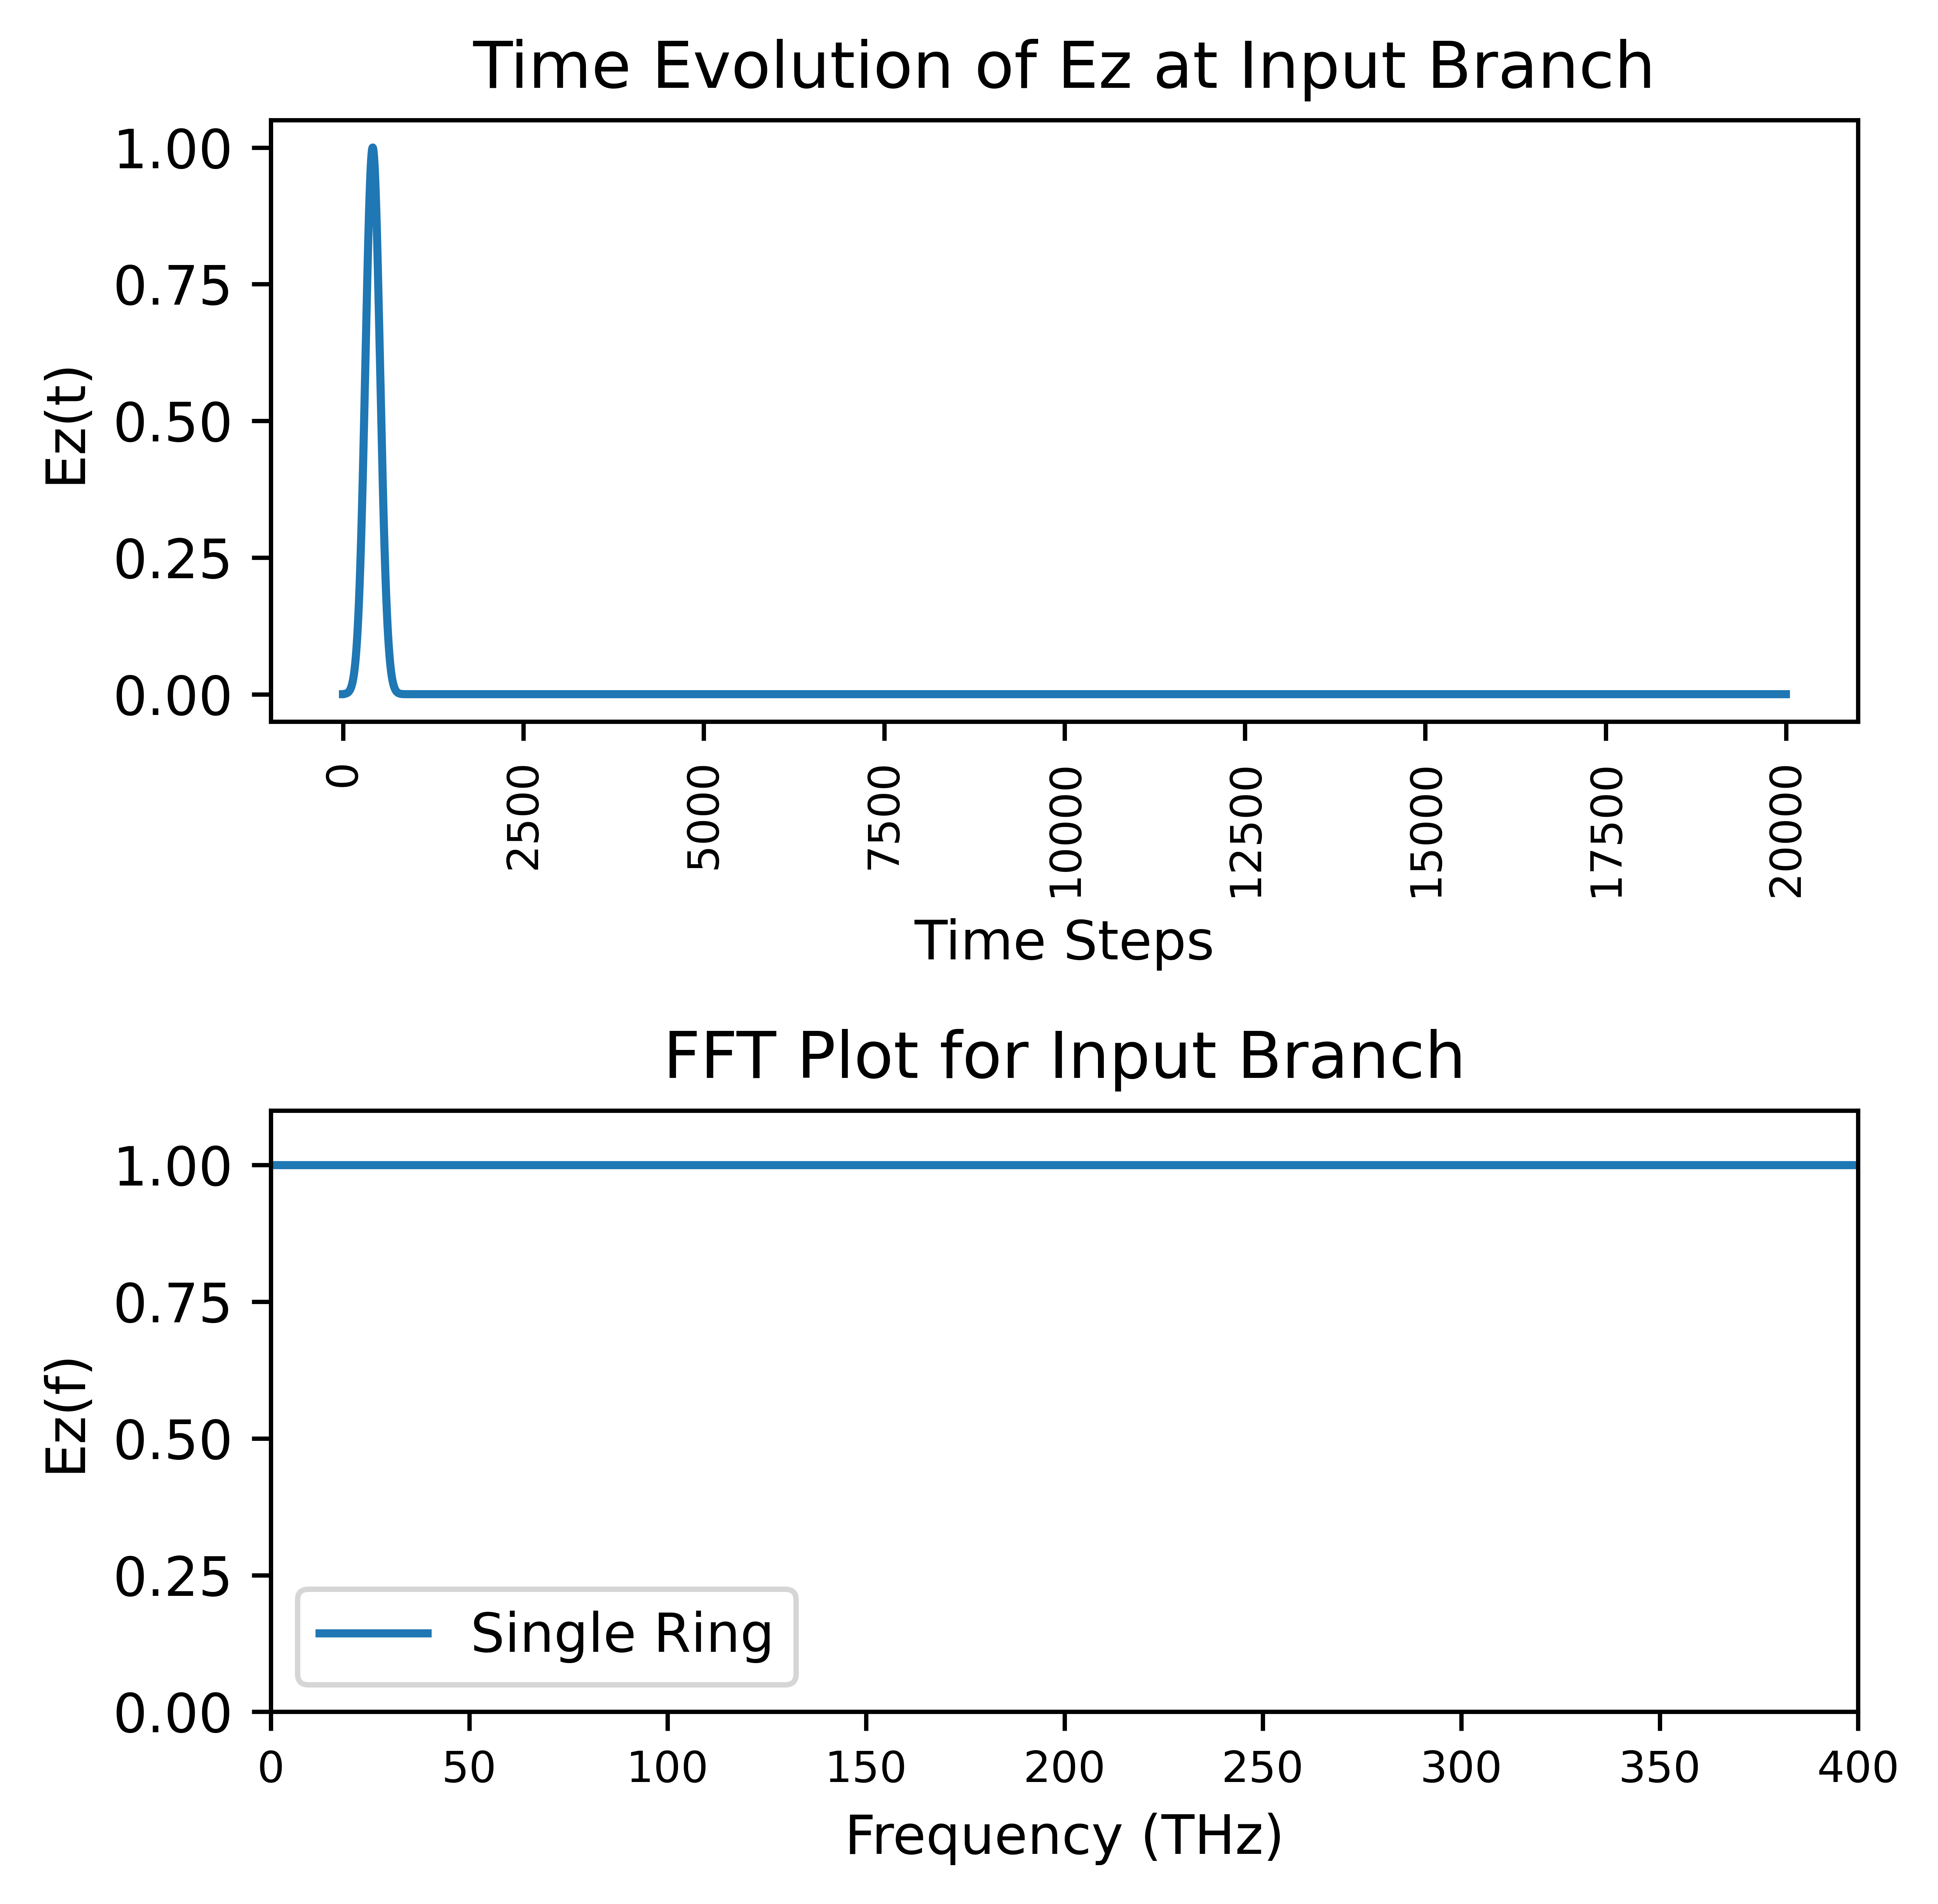

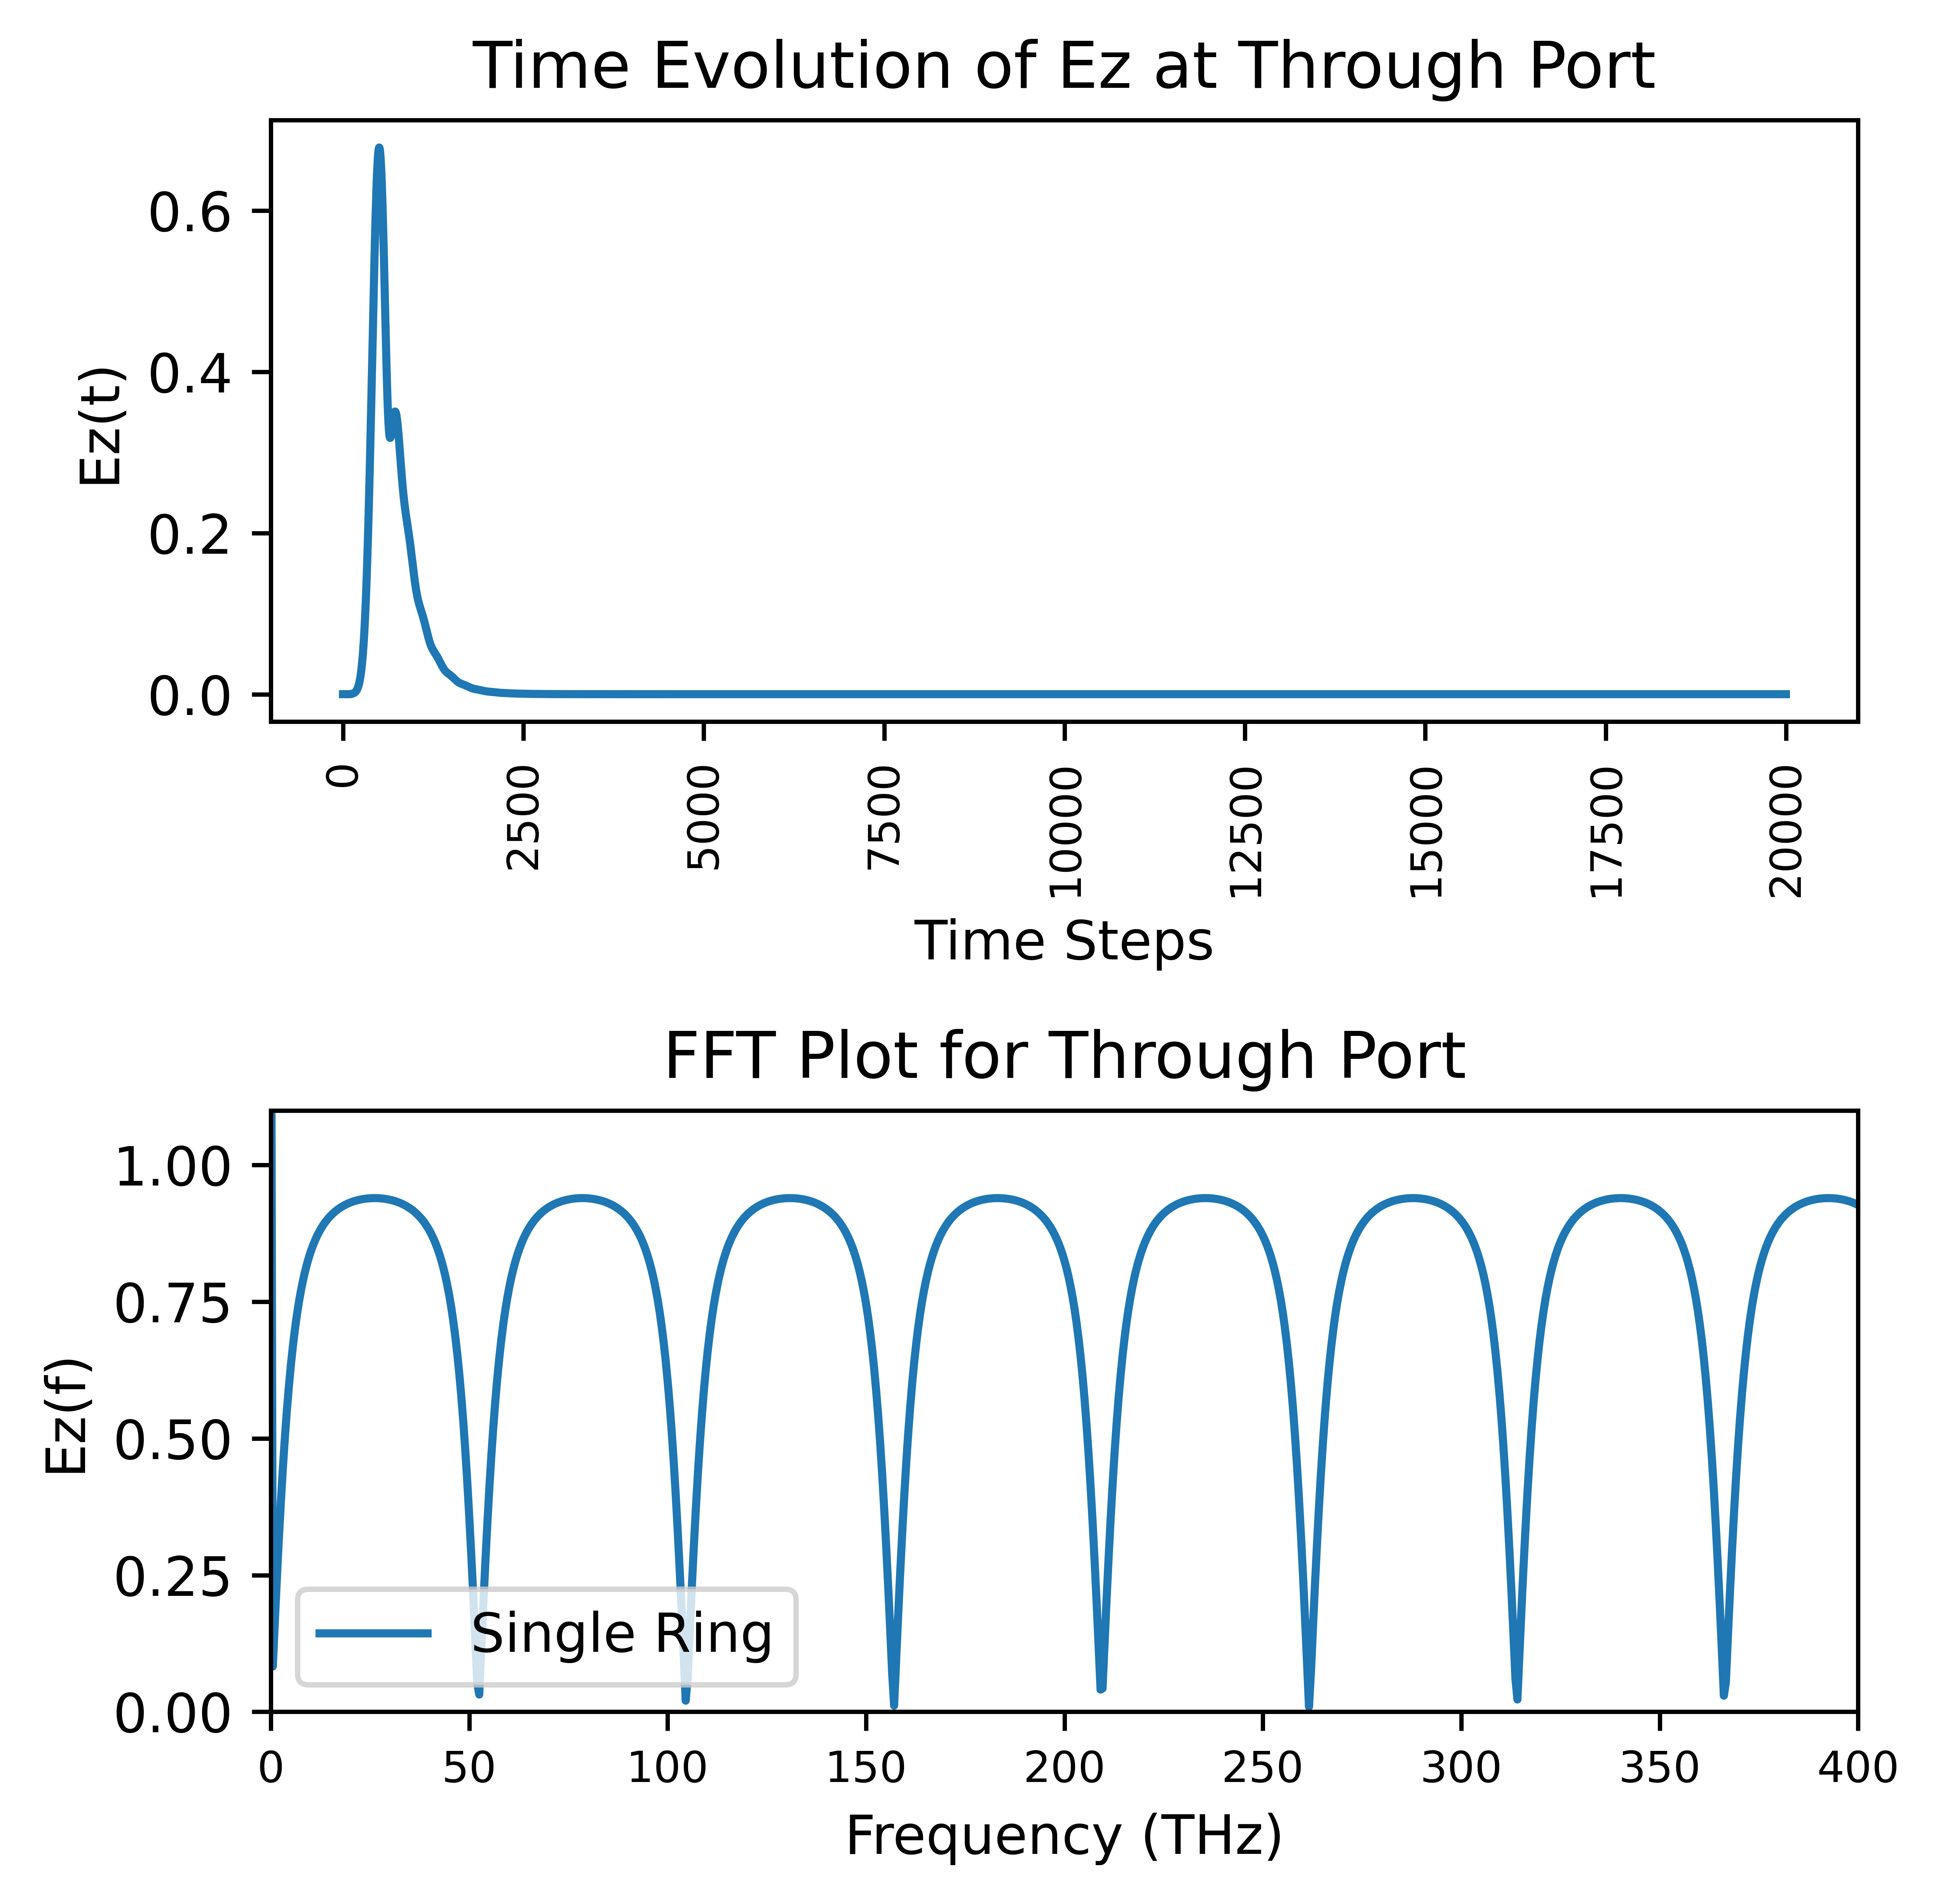

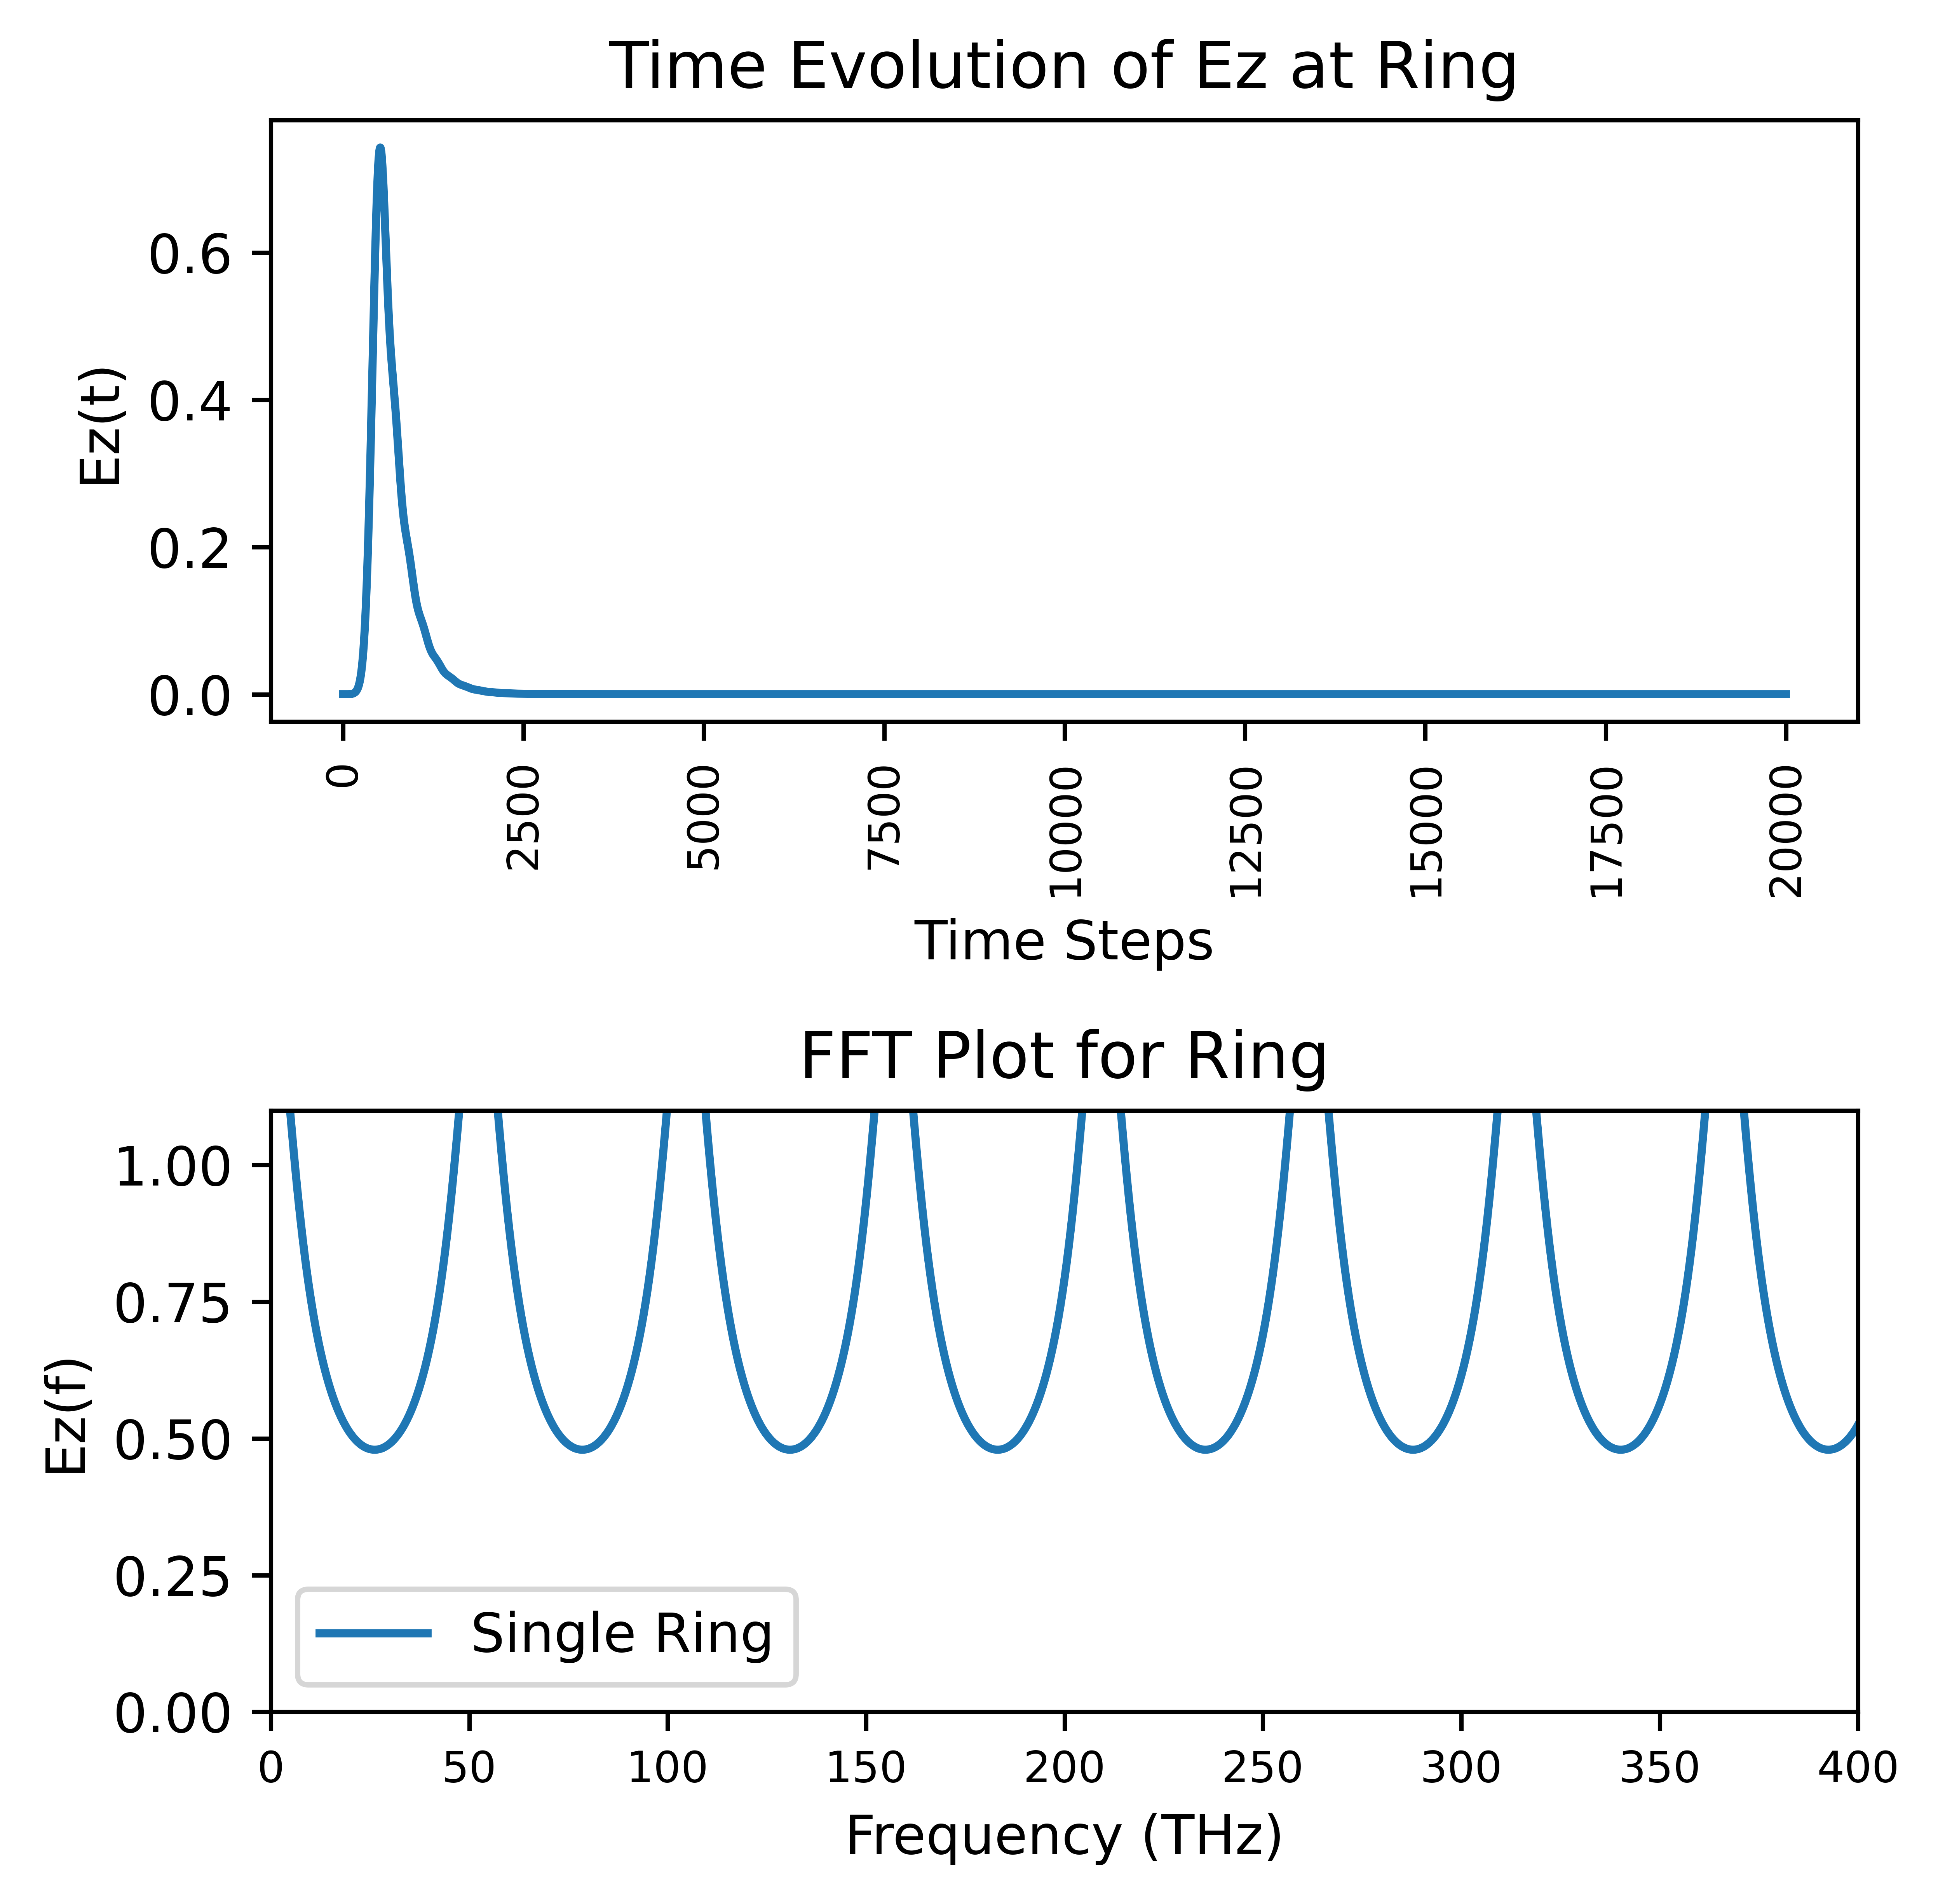

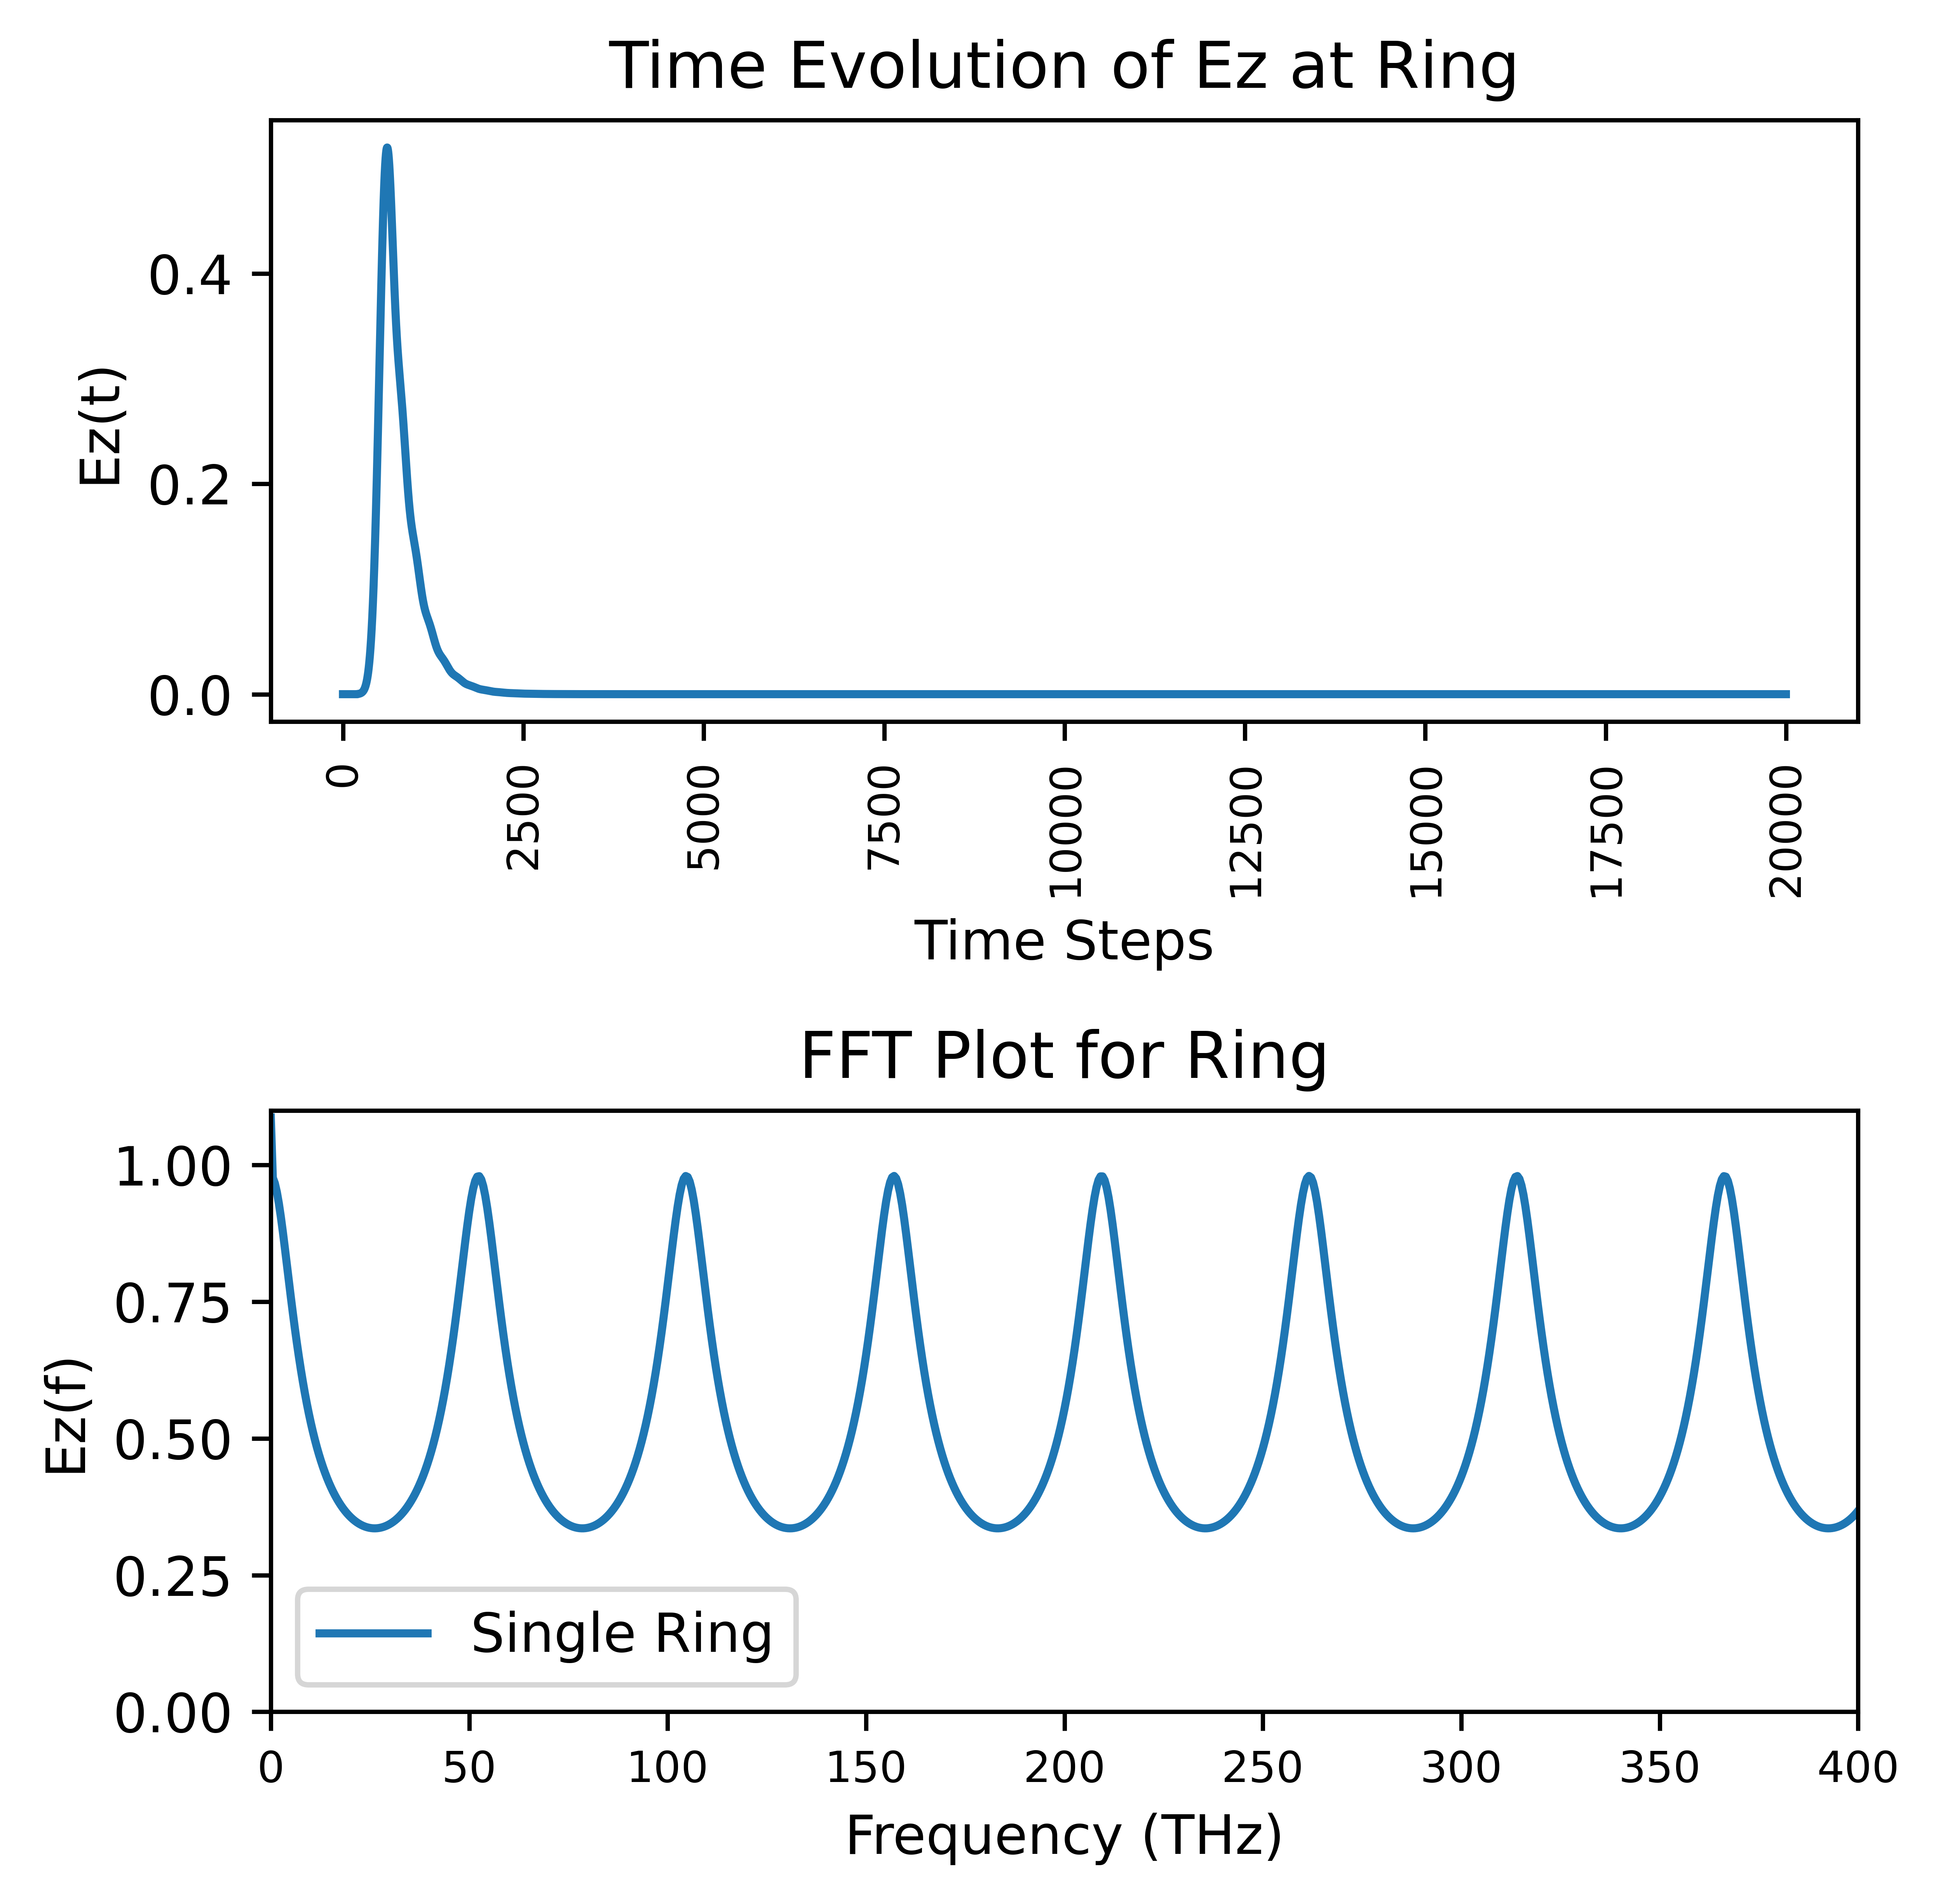

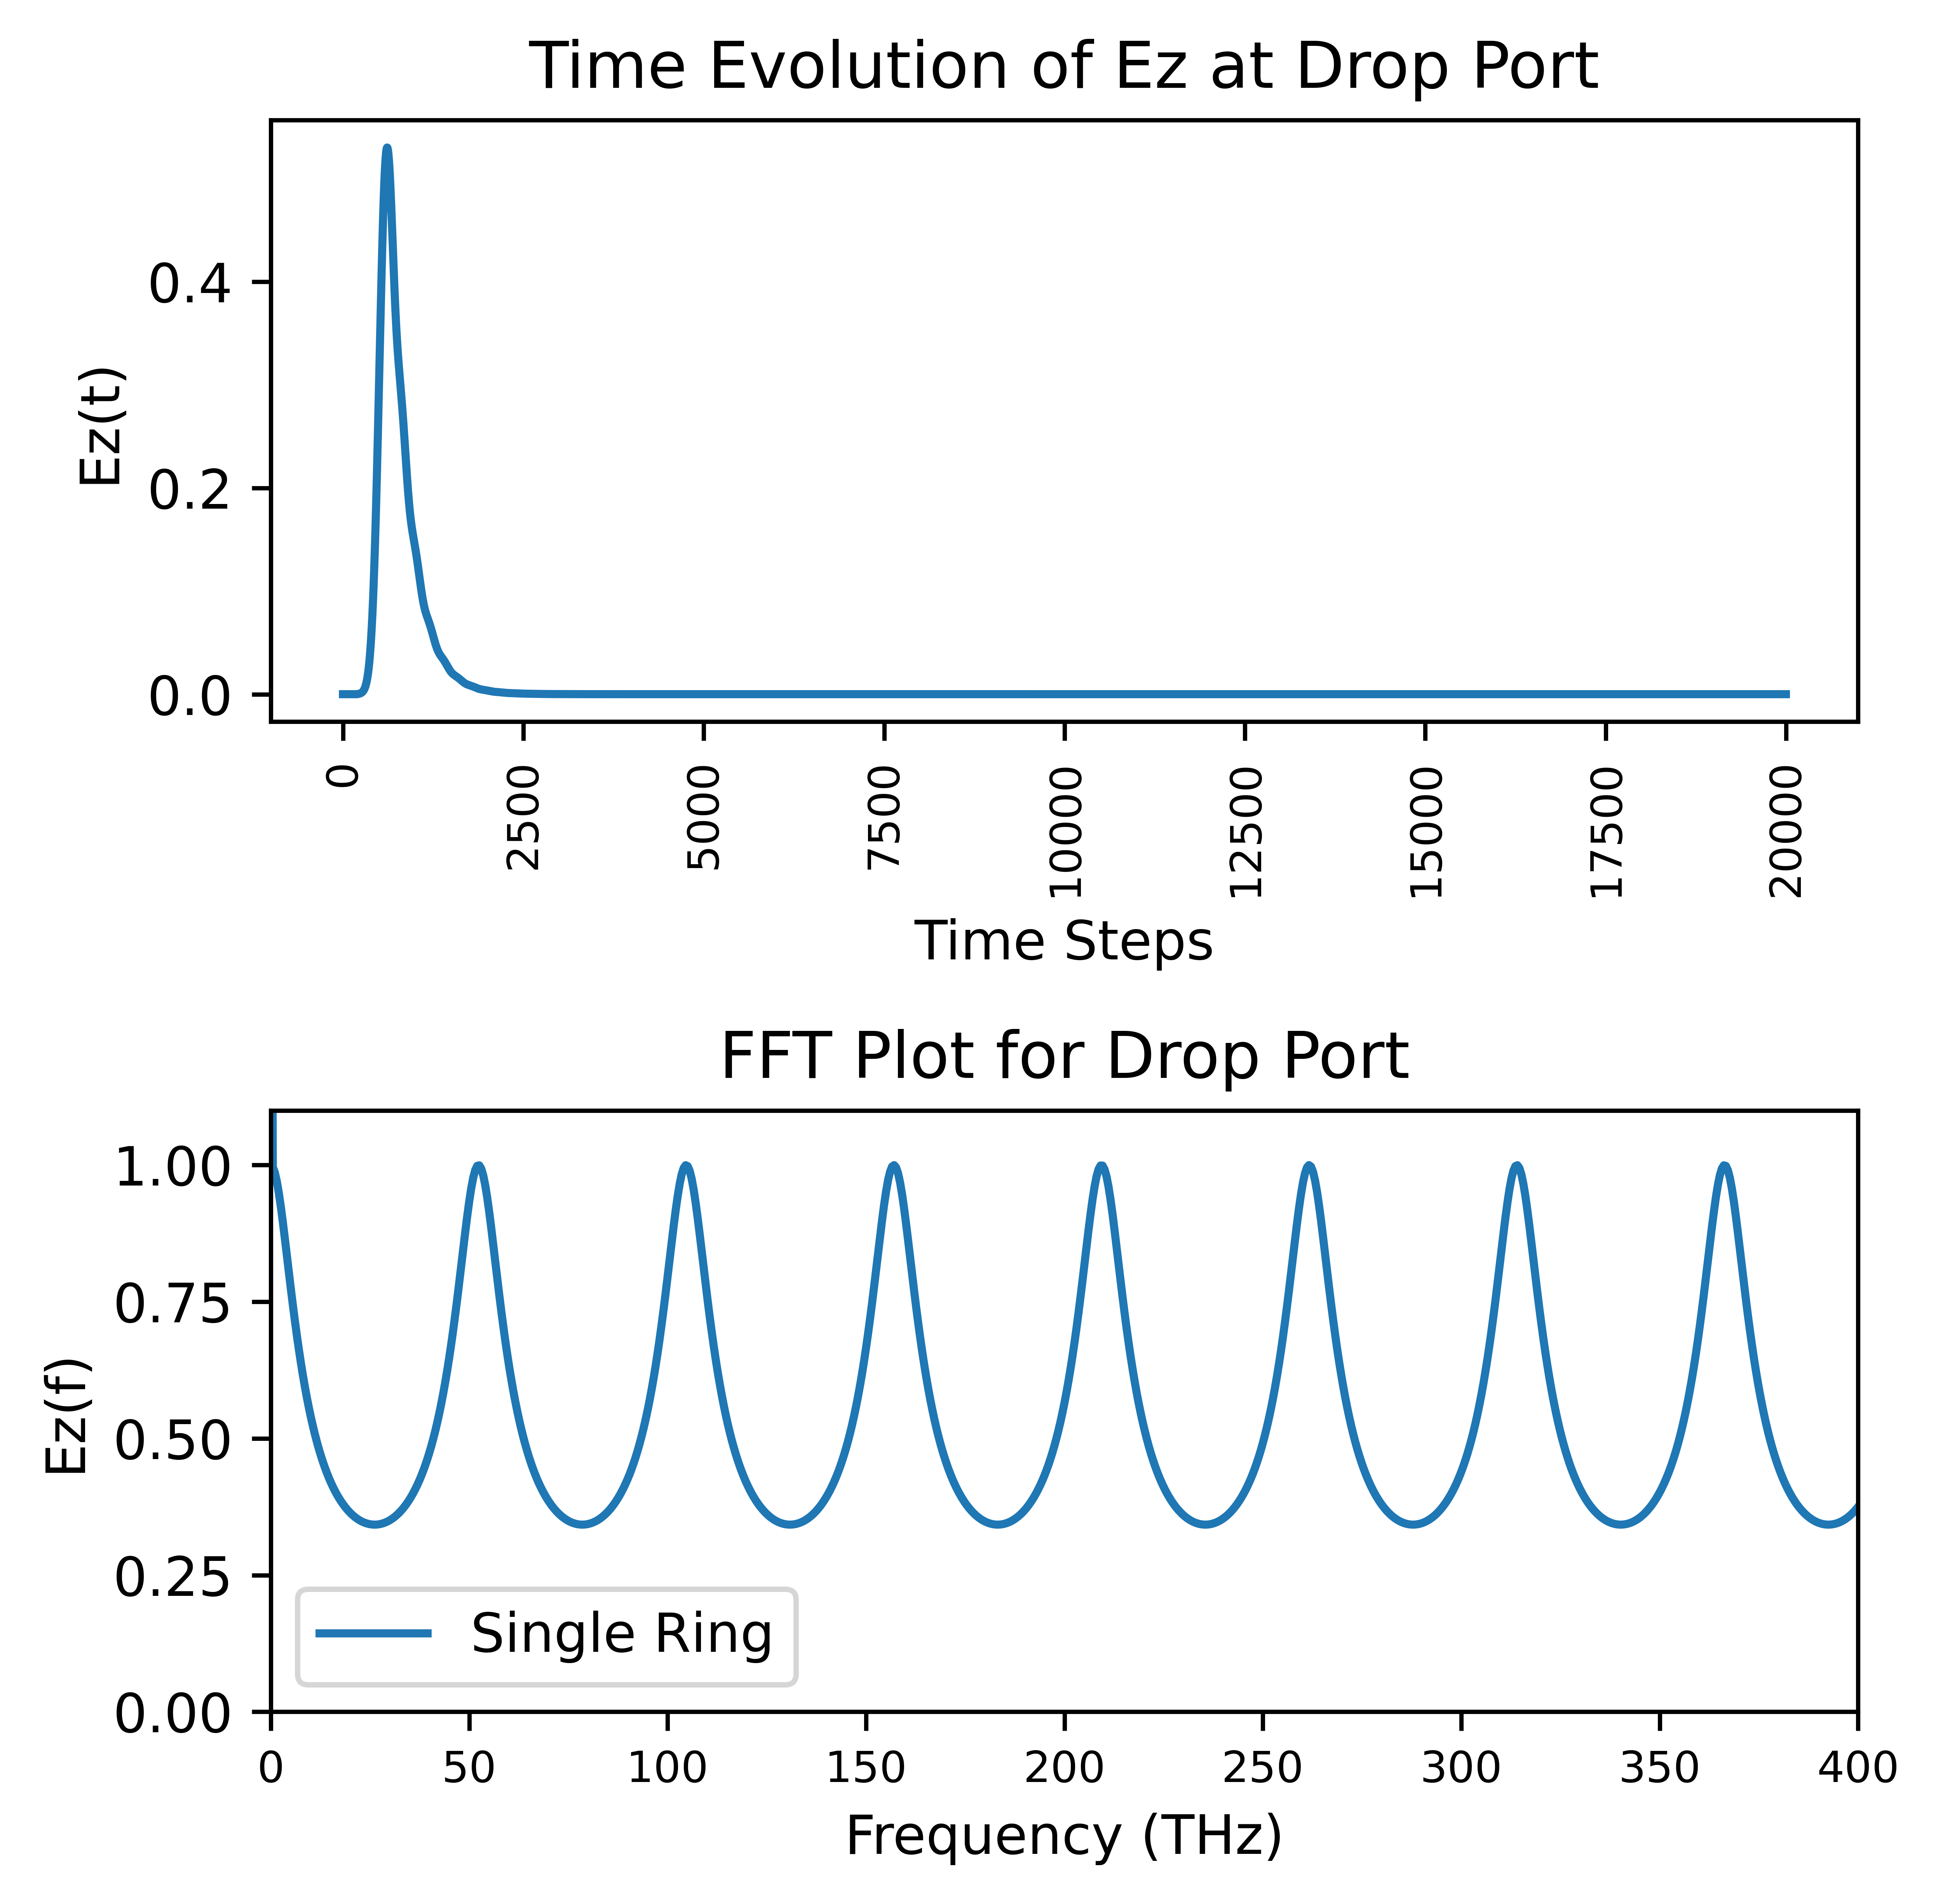

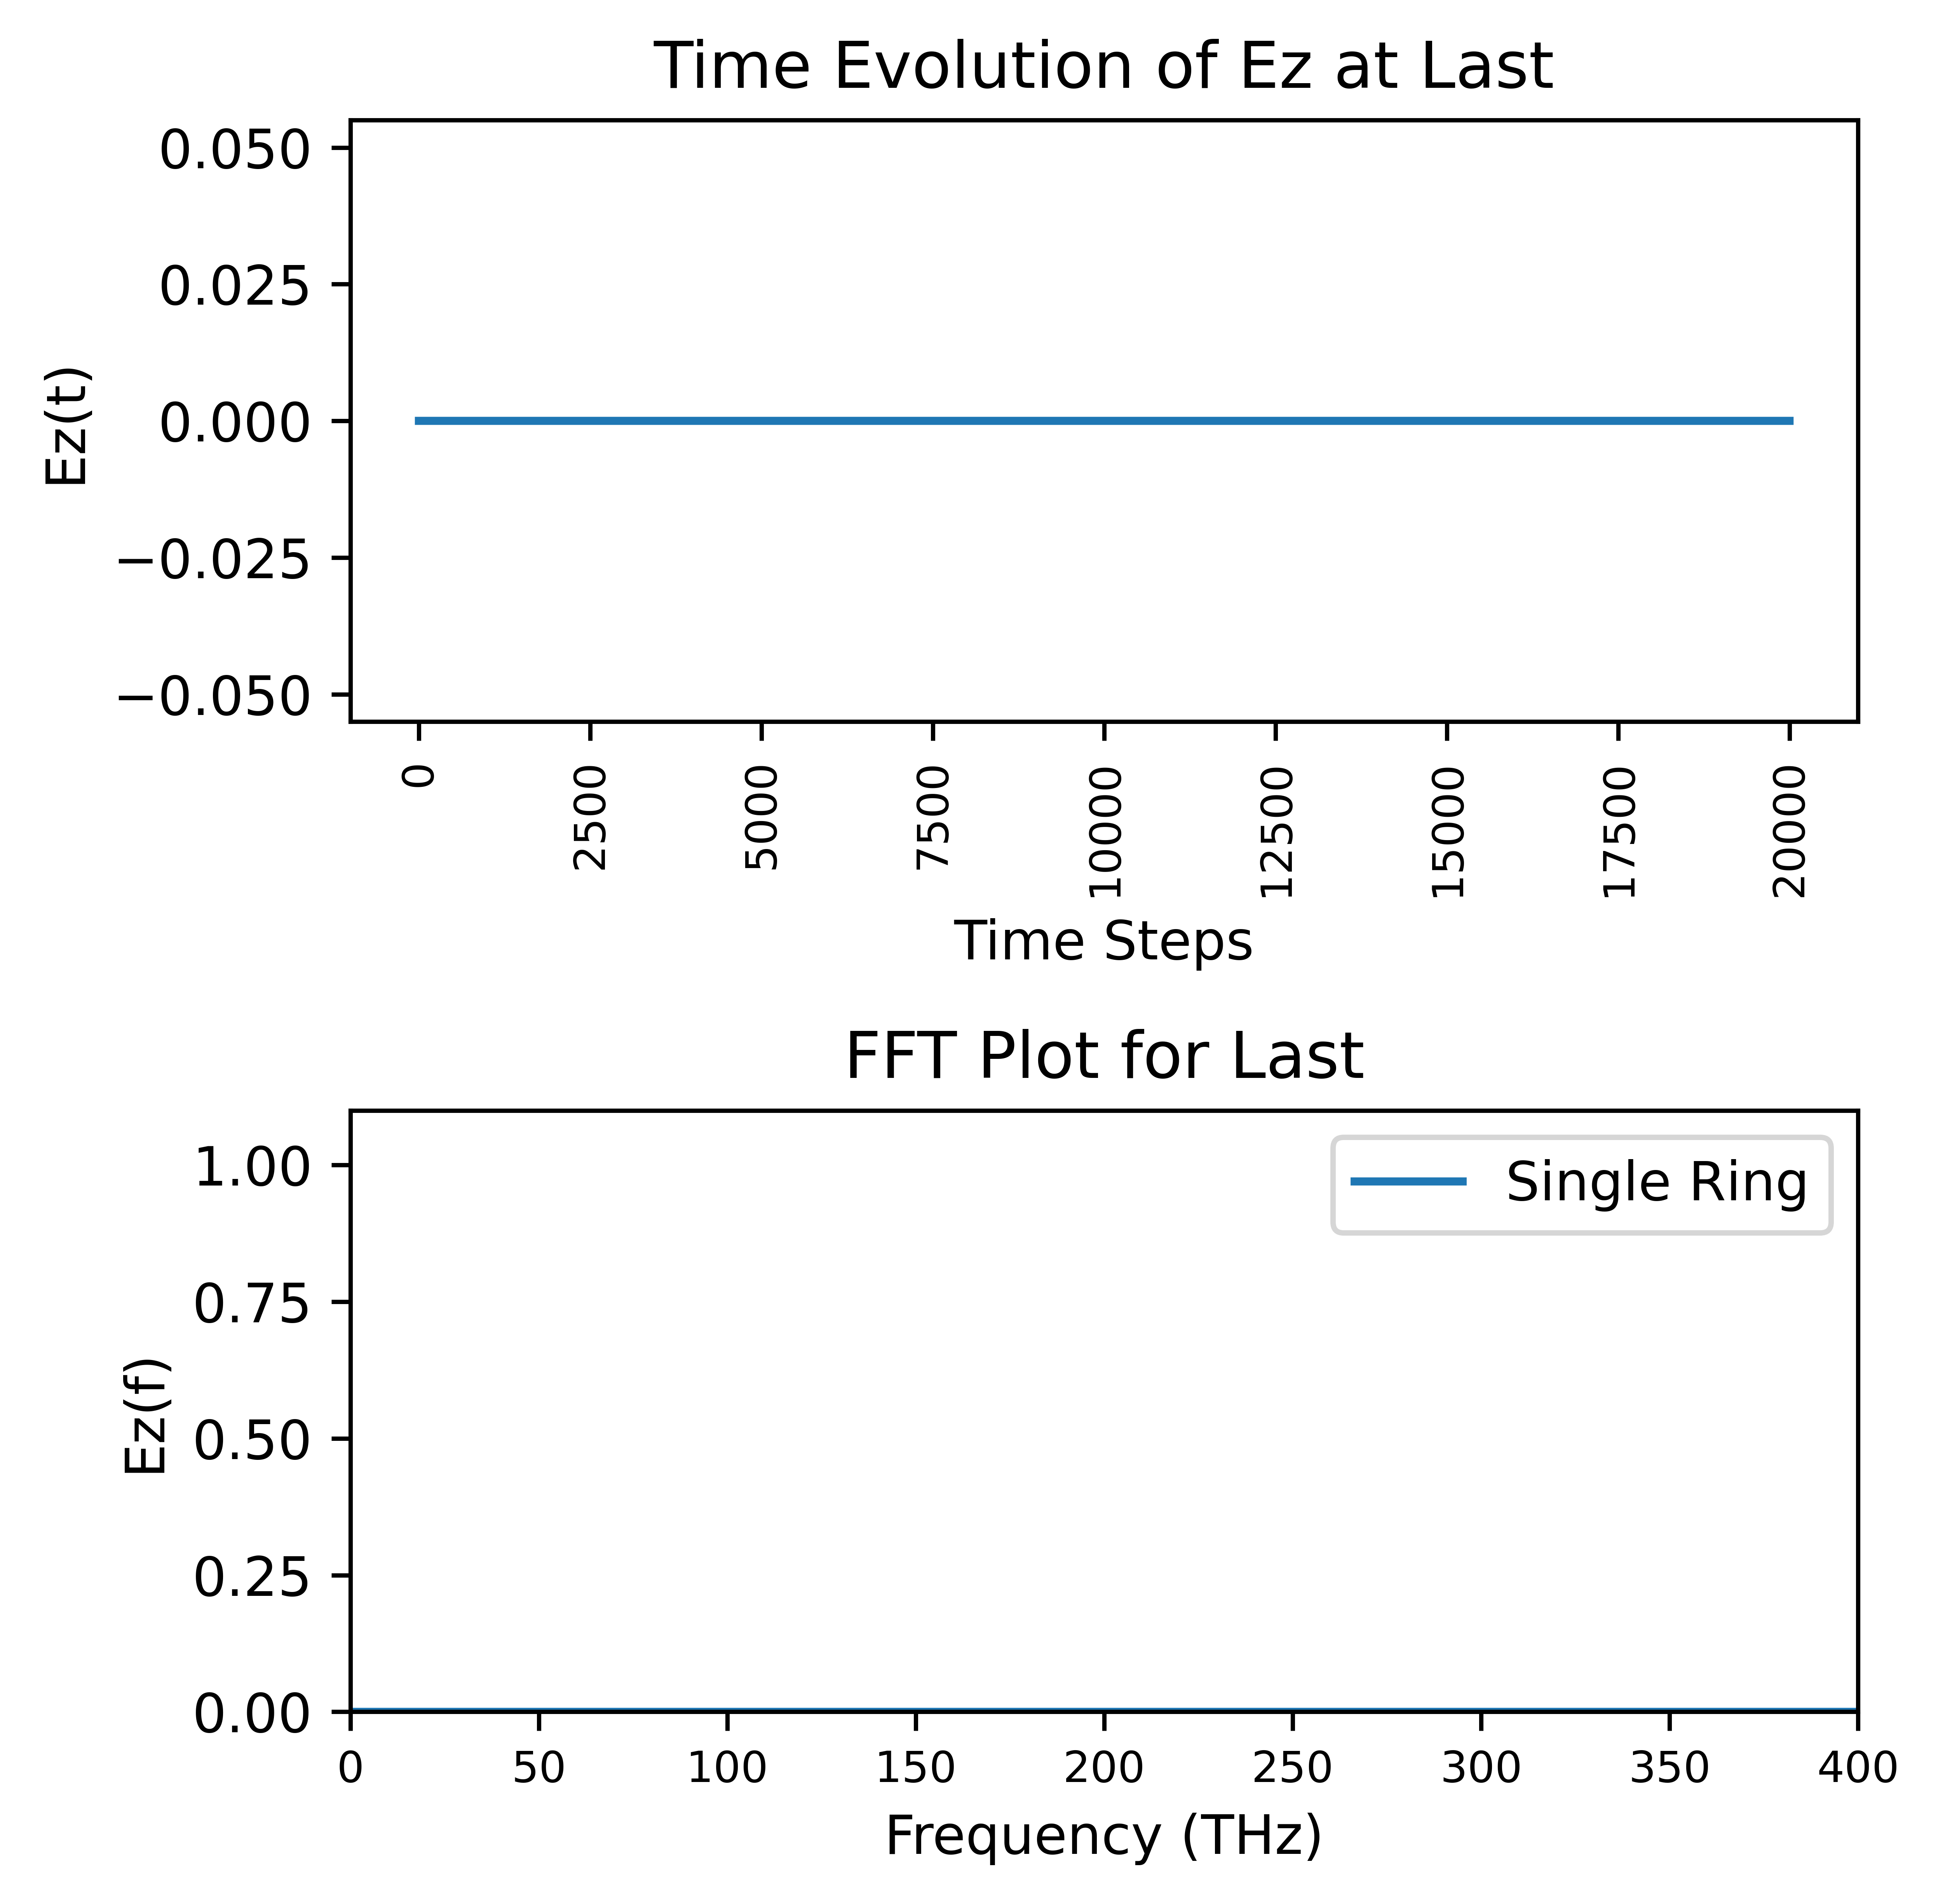

In [106]:
from cProfile import label
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MaxNLocator
from numpy import linspace
from sympy import rotations
titles = ["Input Branch",
          "Through Port",
          "Ring",
          "Ring",
          "Drop Port",
          "Last"]

for ii in range(N_seg):
    # plt.figure(figsize=(5,5), dpi=1000)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,5), dpi = 1000)

    # First subplot
    ax1.plot(np.abs(Ez[:, ii]), label="Single Ring")
    ax1.set_ylabel("Ez(t)")
    ax1.set_xlabel("Time Steps")

    # Integer ticks
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Rotate ticks safely
    ax1.tick_params(axis='x', rotation=90, labelsize = 8)
    # ax1.set_xticklabels(ax1.get_xticks(), rotation=90)
    # ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x)}"))
    ax1.set_title(f"Time Evolution of Ez at {titles[ii]}")

    # Second subplot
    ax2.plot(freqs, np.abs(spectrum[:, ii]/ spectrum[:, 0]), label="Single Ring")
    ax2.set_xlim(0, 4e14)
    ax2.set_ylim(0, 1.1)

    # Apply formatter here
    ax2.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: f"{x/1e12:.0f}")
    )

    ax2.set_xlabel("Frequency (THz)")
    ax2.set_ylabel("Ez(f)")
    ax2.tick_params(axis='x', labelsize = 8)
    ax2.set_title(f"FFT Plot for {titles[ii]}")

    plt.tight_layout()
    plt.legend()
    plt.show()

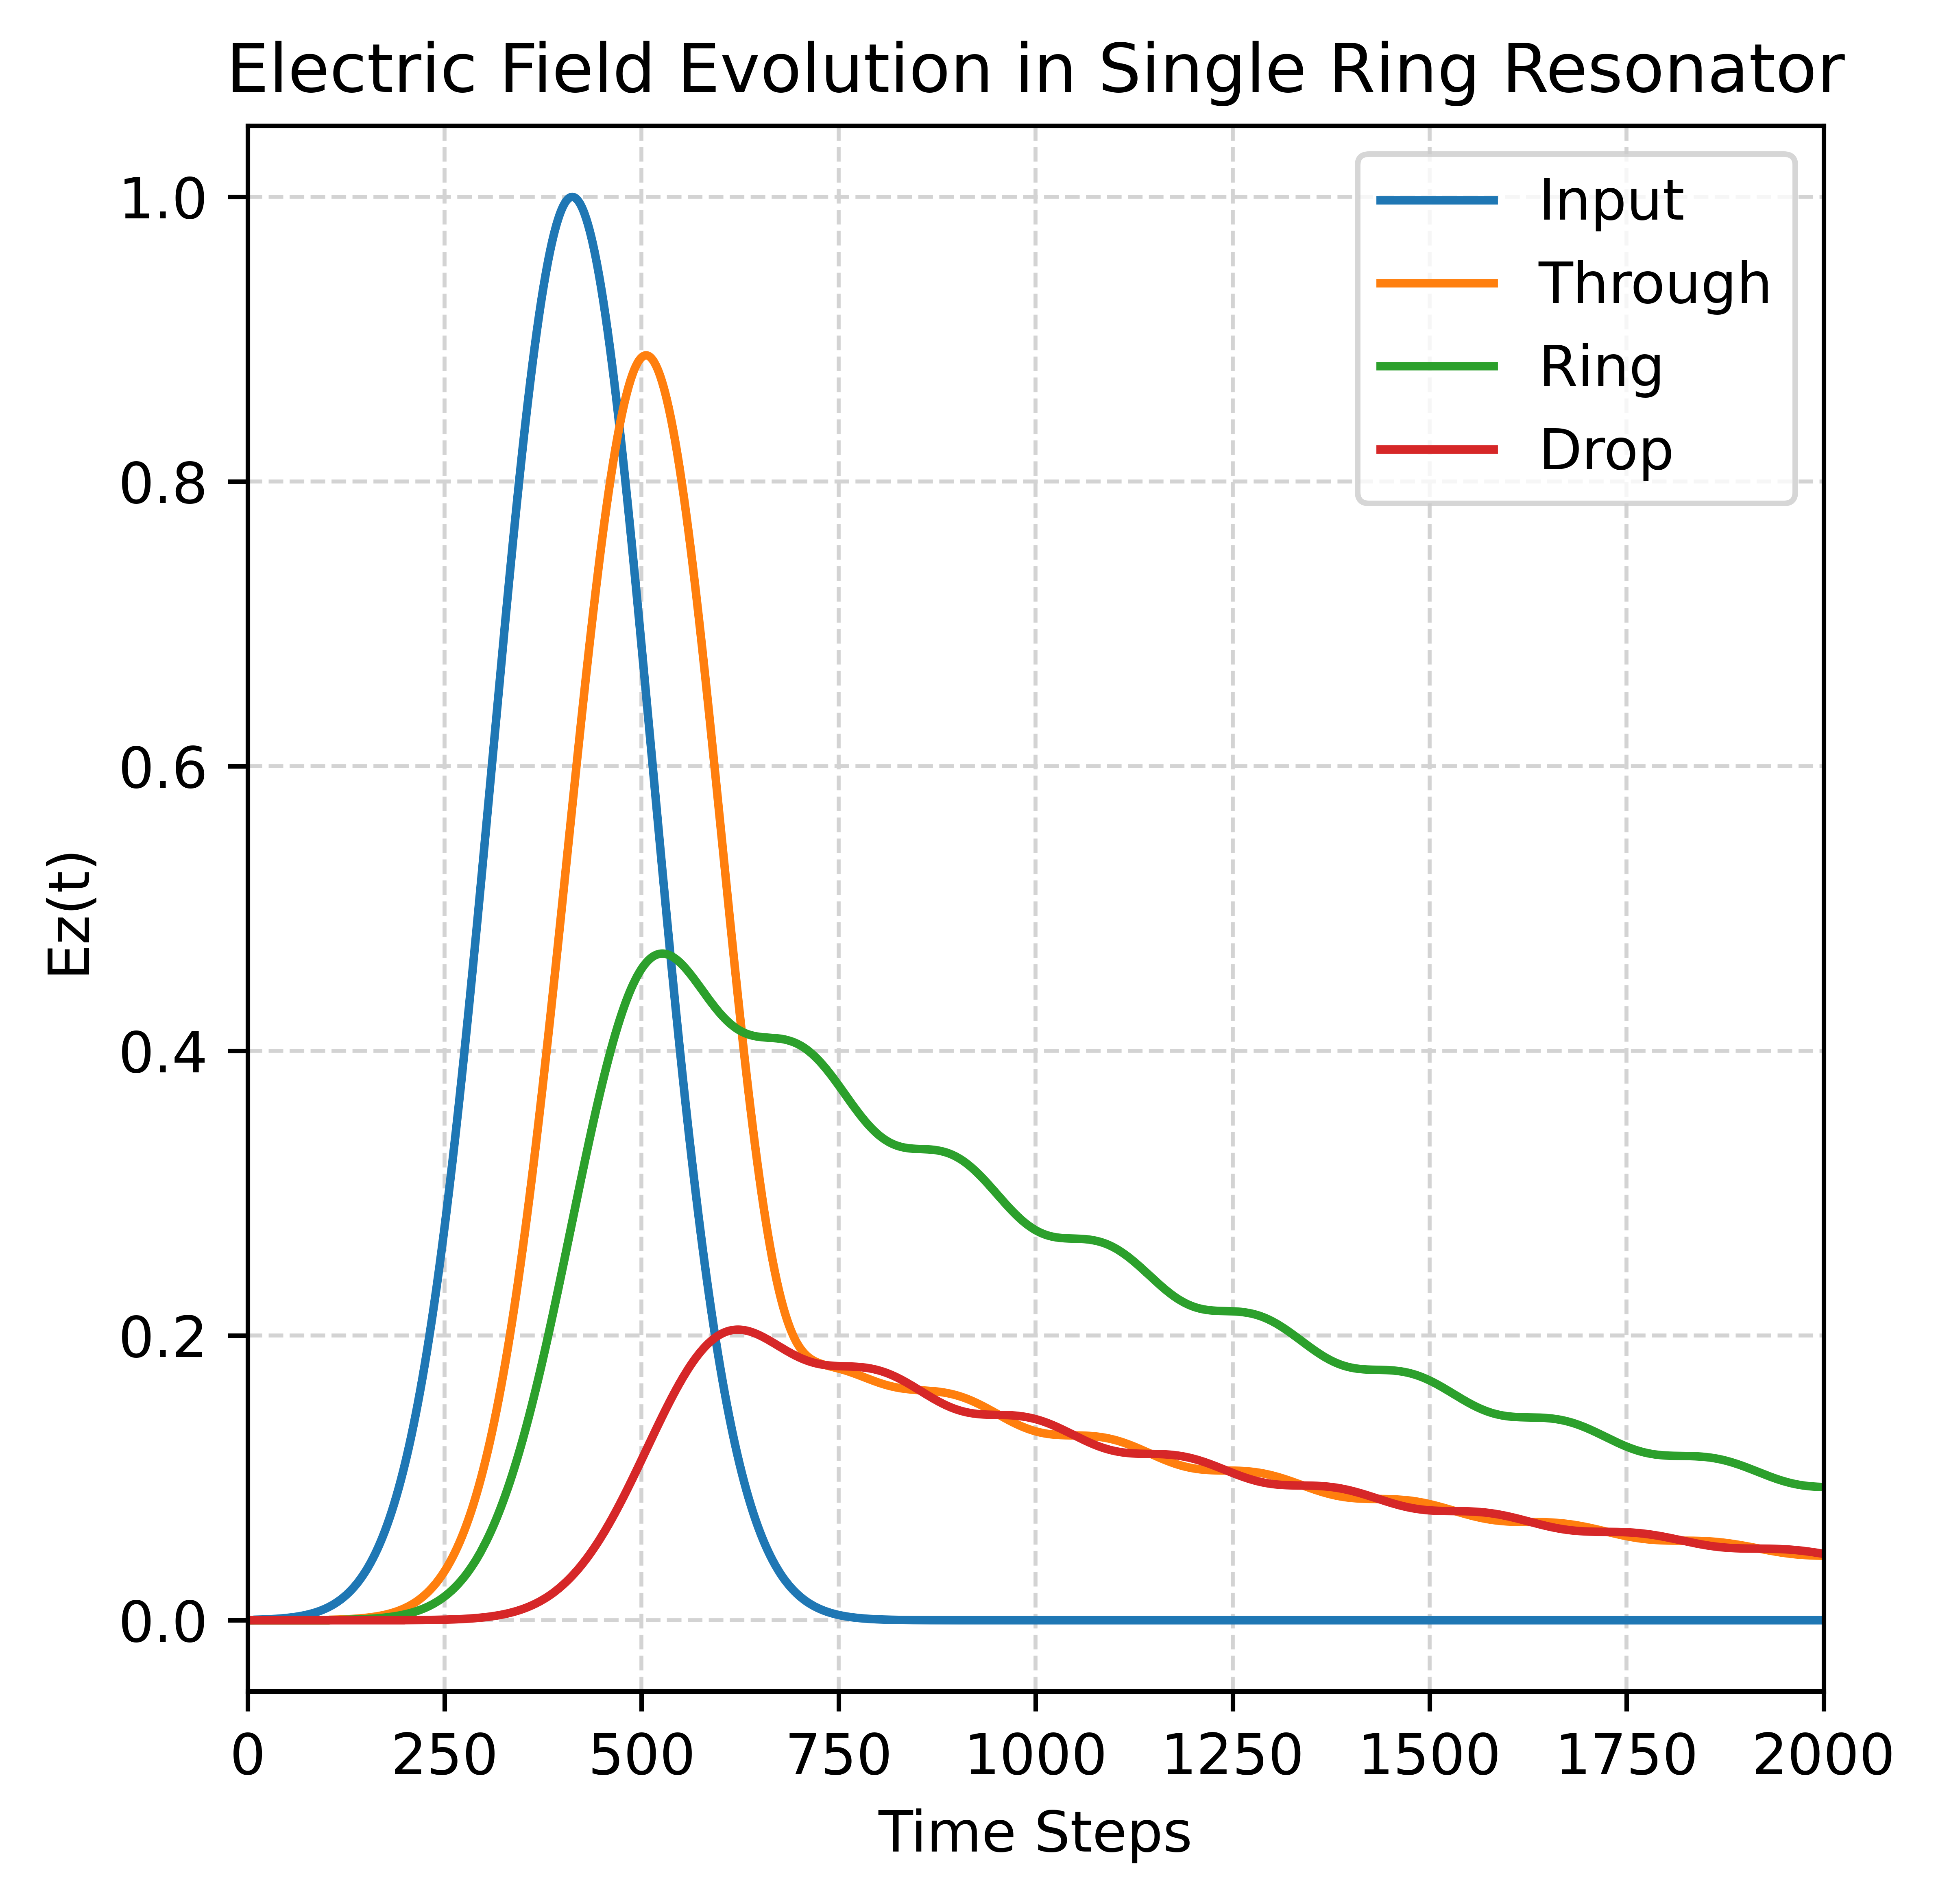

In [ ]:
plt.figure(figsize=(5,5), dpi = 1000)
plt.plot(np.abs(Ez[:,0]), label="Input")
plt.plot(np.abs(Ez[:,1]), label="Through")
plt.plot(np.abs(Ez[:,2]), label="Ring")
plt.plot(np.abs(Ez[:,N_seg-2]), label="Drop")
plt.xlim(0,2000)
plt.title("Electric Field Evolution in Single Ring Resonator")
plt.xlabel("Time Steps")
plt.ylabel("Ez(t)")
plt.legend()
plt.grid(True, color="lightgrey", linestyle="--", linewidth=0.7)
plt.show()

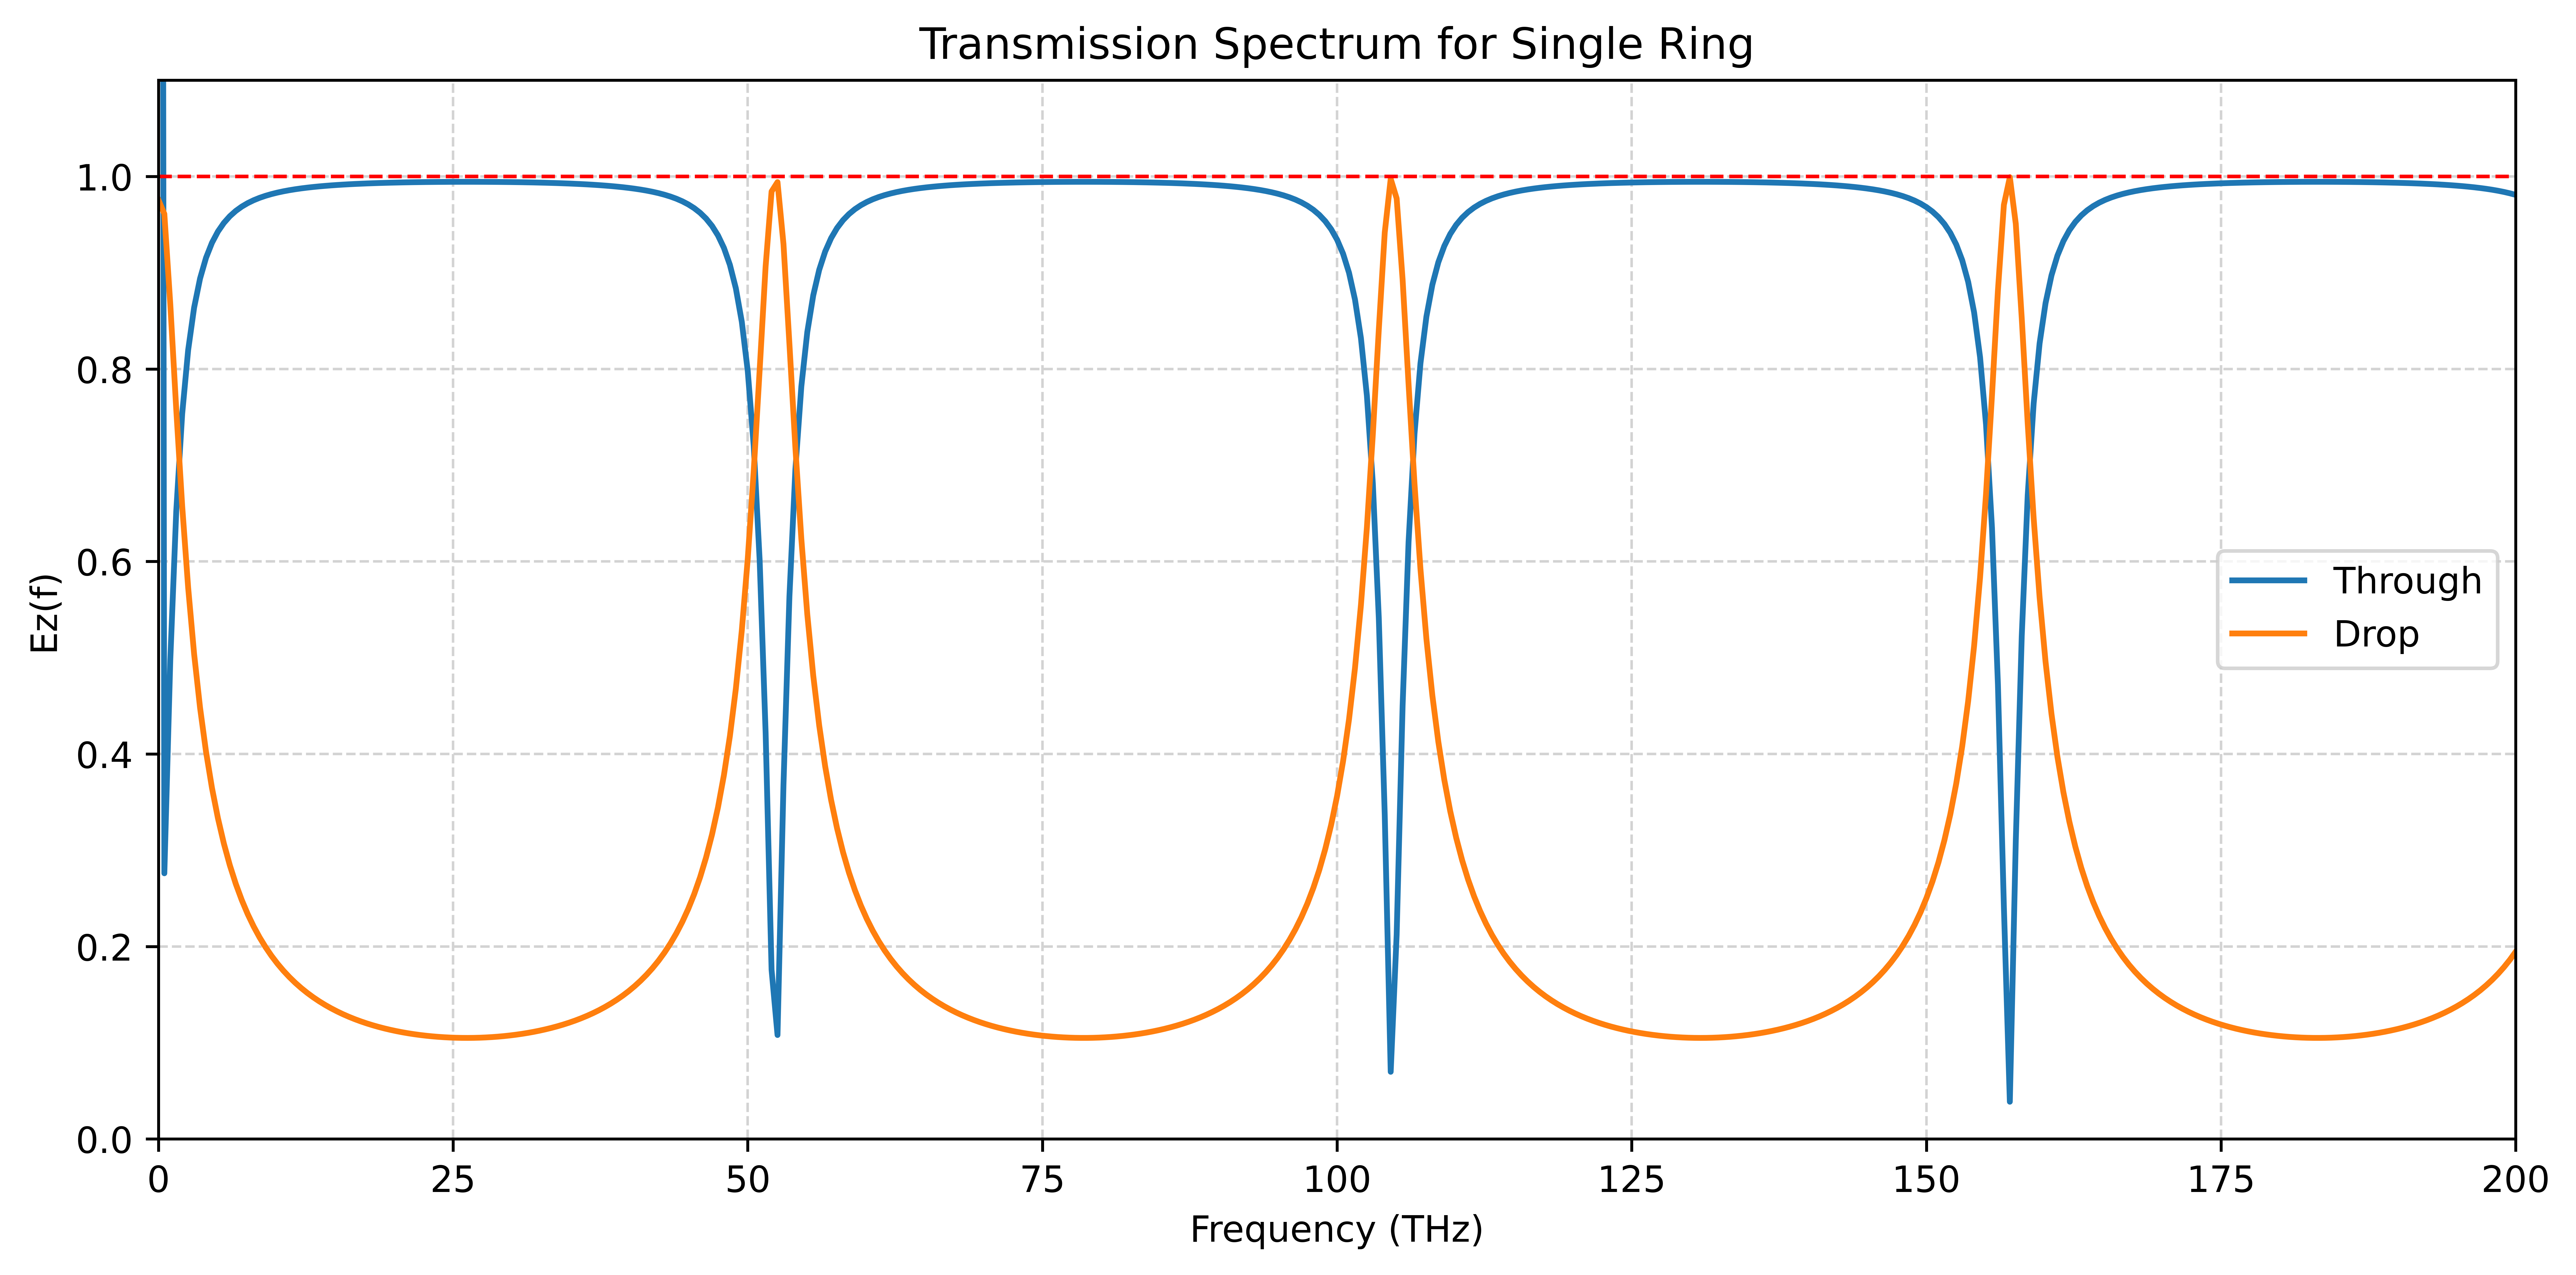

In [ ]:

fig, ax = plt.subplots(figsize=(10, 5), dpi=1000)

ax.plot(freqs, np.abs(spectrum[:, 1] / spectrum[:, 0]), label="Through", linewidth = 1.6)
ax.plot(freqs, np.abs(spectrum[:, N_seg - 2] / spectrum[:, 0]), label="Drop", lw = 1.6)

ax.set_xlim(0, 2e14)
ax.set_ylim(0, 1.1)

# Horizontal line at y=1
ax.axhline(y=1, color='r', linestyle='--', linewidth=1)

# Apply formatter to x-axis (THz instead of Hz)
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f"{x/1e12:.0f}")
)

ax.set_xlabel("Frequency (THz)")
ax.set_ylabel("Ez(f)")
ax.set_title("Transmission Spectrum for Single Ring")
ax.legend()
plt.grid(True, color="lightgrey", linestyle="--", linewidth=0.7)


plt.tight_layout()
plt.show()


IndexError: boolean index did not match indexed array along dimension 0; dimension is 19999 but corresponding boolean dimension is 10000

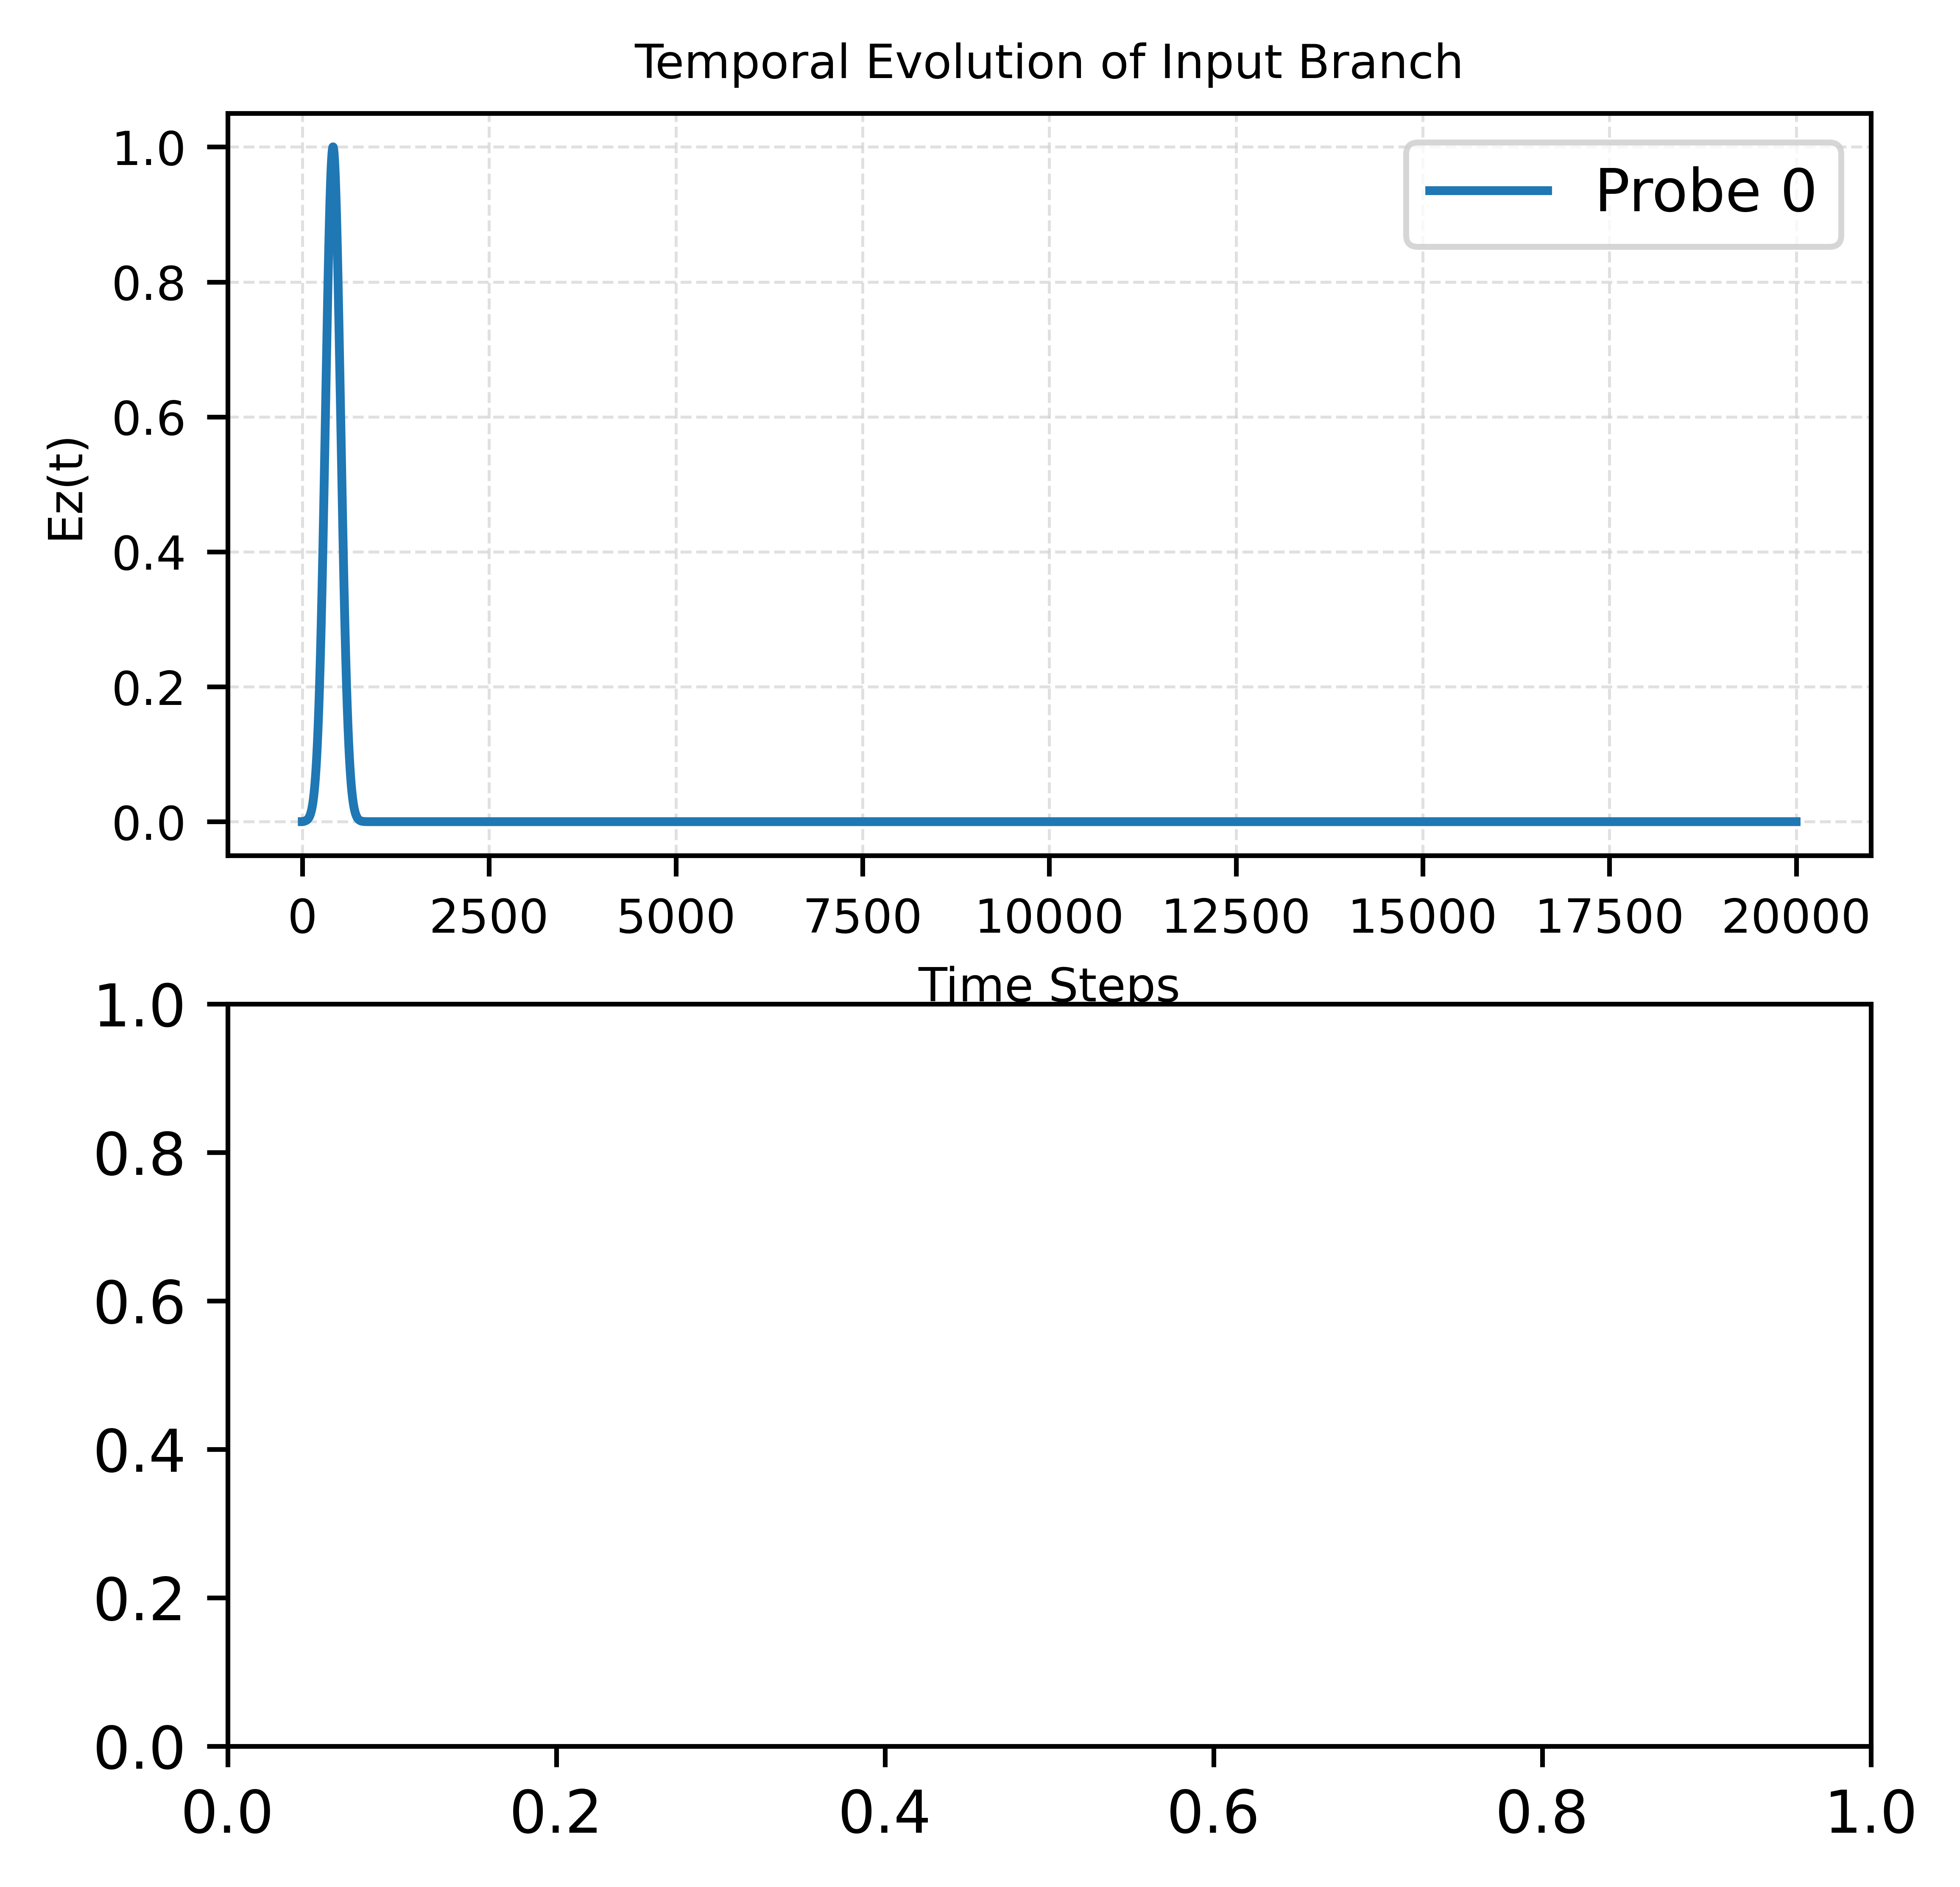

In [ ]:
from matplotlib.pyplot import subplots_adjust
titles = ["Input Branch",
          "Through Port",
          "2",
          "3",
          "Drop Port",
          "Last"]


S_ref = np.fft.fftshift(np.fft.fft(Ez[:,0]))/N

for ii in range(N_seg):
    S_out = np.fft.fftshift(np.fft.fft(Ez[:,ii]))/N
    H = S_out / (S_ref + 1e-30)  # avoid divide-by-zero

    pos = freqs > 0
    plt.figure(figsize=(5,5), dpi=1000)

    # --- first subplot ---
    ax1 = plt.subplot(2,1,1)
    ax1.plot(np.abs(Ez[:,ii]), label=f"Probe {ii}")
    # ax1.set_xlim(0, 20000)
    ax1.set_title(f"Temporal Evolution of {titles[ii]}", fontsize=8)
    ax1.set_xlabel("Time Steps", fontsize=8)
    ax1.set_ylabel("Ez(t)", fontsize=8)
    ax1.tick_params(labelsize=8)
    ax1.legend()
    ax1.grid(True, which="both", color="lightgrey", linestyle="--", linewidth=0.5, alpha=0.7)

    # --- second subplot ---
    ax2 = plt.subplot(2,1,2)
    ax2.plot(freqs[pos]/1e12, 20*np.log10(np.abs(H[pos])), label=f"Probe {ii}")
    ax2.set_xlim(150, 250)
    ax2.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: f"{x/1e12:.0f}")
    )
    ax2.set_title(f"FFT Spectrum of {titles[ii]}", fontsize=8)
    ax2.set_xlabel("Frequency (THz)", fontsize=8)
    ax2.set_ylabel("Ez(f)", fontsize=8)
    ax2.tick_params(labelsize=8)
    ax2.legend()
    ax2.grid(True, which="both", color="lightgrey", linestyle="--", linewidth=0.5, alpha=0.7)

    # --- adjust subplot spacing ---
    plt.subplots_adjust(hspace=0.5)

    plt.show()

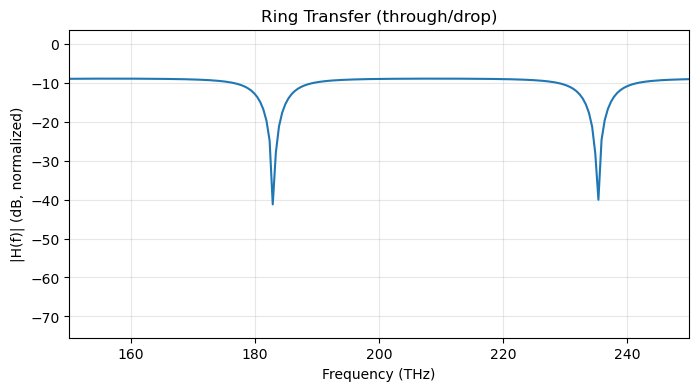

In [ ]:
# ref_s: Ez recorded at a reference probe near the source (same length as s3)
S_out = np.fft.fftshift(np.fft.fft(Ez[:,1]))/N
S_ref = np.fft.fftshift(np.fft.fft(Ez[:,0]))/N
H = S_out / (S_ref + 1e-30)  # avoid divide-by-zero

# Plot only positive freqs (complex source -> one-sided)
pos = freqs > 0
plt.figure(figsize=(8,4))
plt.plot(freqs[pos]/1e12, 20*np.log10(np.abs(H[pos])/np.max(np.abs(H[pos]))))
plt.xlim(150, 250)
plt.xlabel("Frequency (THz)"); plt.ylabel("|H(f)| (dB, normalized)")
plt.title("Ring Transfer (through/drop)")
plt.grid(True, alpha=0.3)
plt.show()


(150.0, 250.0)

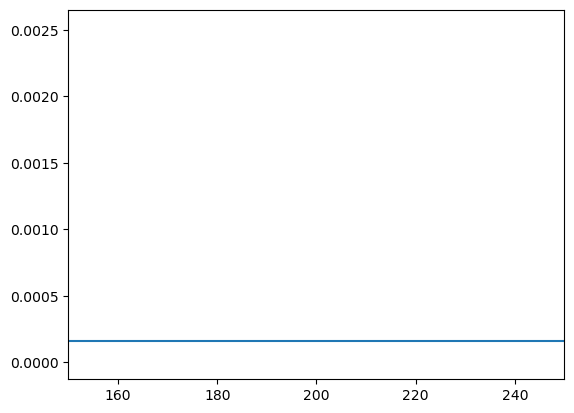

In [ ]:
pos = freqs>0
plt.plot(freqs[pos]/1e12,(np.abs(S_ref[pos])))
plt.xlim(150, 250)  
# plt.plot(freqs, S_ref)

In [ ]:
from scipy.signal import find_peaks

res_freq = []
signal = spectrum[:,1] #taking the through port

peaks, _ = find_peaks(signal)

res_freq = freqs[peaks]/1e12

# # Example: take one probe (say ii=0)
# spec = np.abs(spectrum[:, 1])
# spec /= np.max(spec)  # normalize

# # find peaks above 10% of max, with min spacing
# peaks, _ = find_peaks(spec, height=0.1, distance=10)

# # Extract resonant freqs in Hz
# resonant_freqs = freqs[peaks]

# # Convert to THz for readability
# resonant_freqs_THz = resonant_freqs / 1e12

print("Resonant frequencies (THz):", res_freq)


Resonant frequencies (THz): [  52.52787892  104.55068208  159.60393979  209.10136416  314.157122
  366.17992516  418.70780408  471.235683    523.25848616  575.78636508
  627.80916824  680.33704716  732.86492607  784.88772923  837.41560815
  889.94348707  941.96629023  994.49416915 1046.51697231 1099.04485123
 1151.57273015 1203.59553331 1256.12341223 1308.65129115 1360.67409431
 1413.20197323 1465.22477639 1517.75265531 1570.28053423 1622.30333739
 1674.83121631 1727.35909523 1779.38189839 1831.90977731 1883.93258047
 1936.46045939 1988.98833831 2041.01114147 2093.53902039 2145.56182355
 2198.08970246 2250.61758138 2302.64038454 2355.16826346 2407.69614238
 2459.71894554 2512.24682446 2564.26962762 2616.79750654 2669.32538546
 2721.34818862 2773.87606754 2826.40394646 2878.42674962 2930.95462854
 2982.9774317  3035.50531062 3088.03318954 3140.0559927  3192.58387162
 3245.11175054 3297.1345537  3349.66243262 3401.68523578 3454.2131147
 3506.74099362 3558.76379678 3611.29167569 3663.8195

(6, 20000, 100)
6


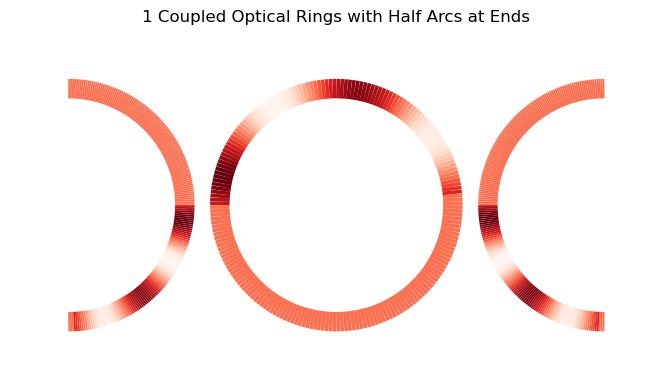

6


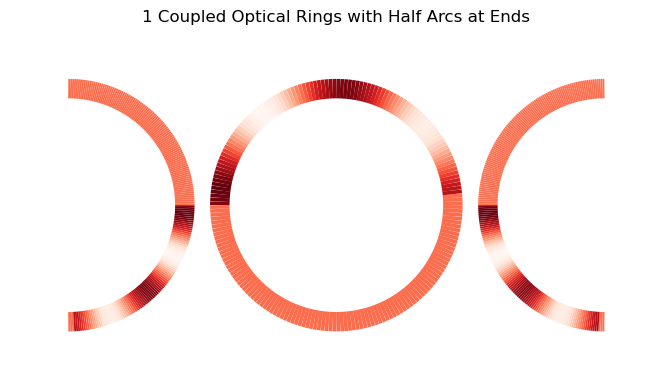

6


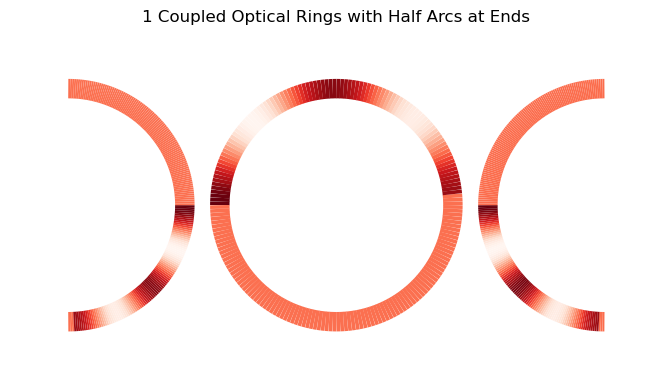

6


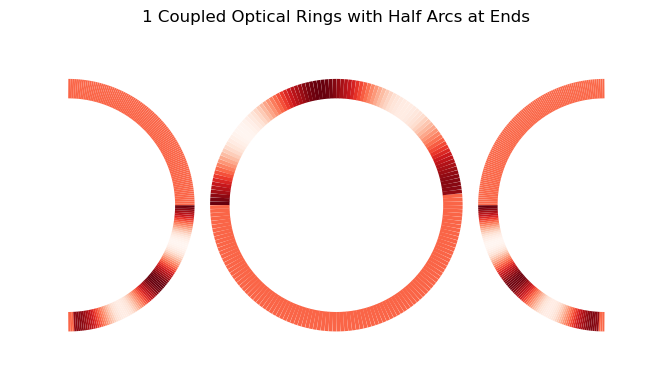

6


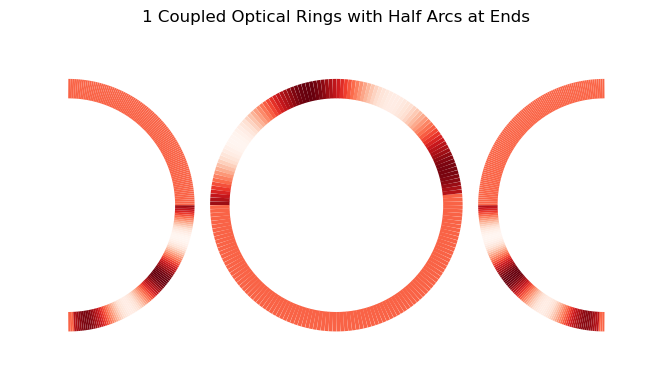

6


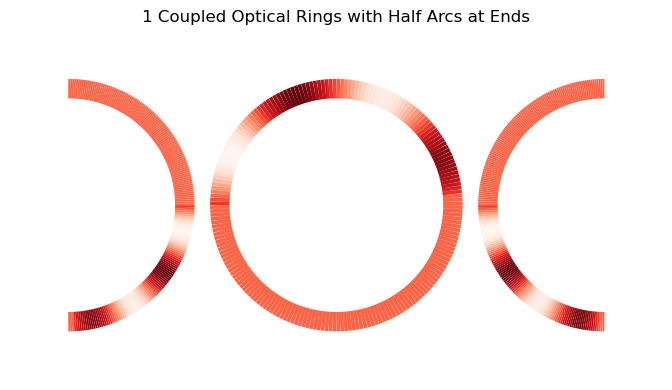

6


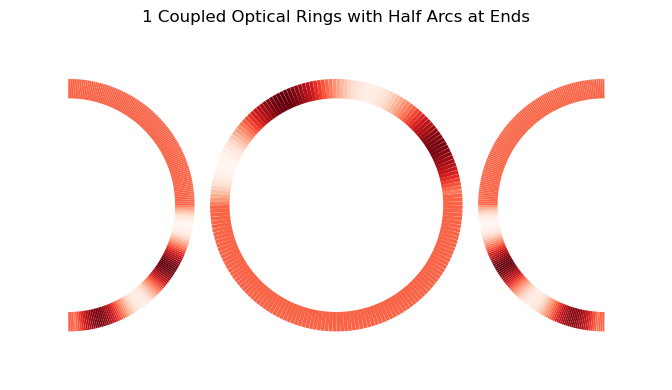

6


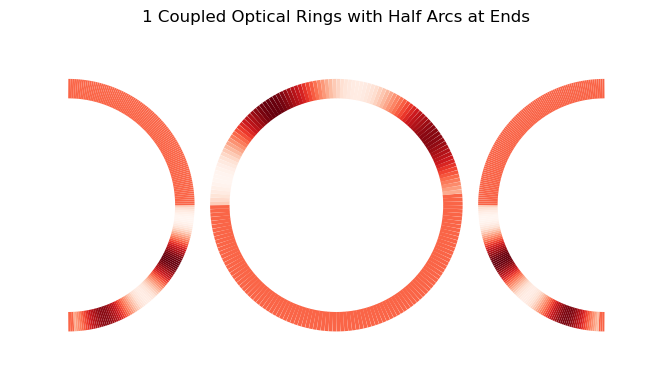

6


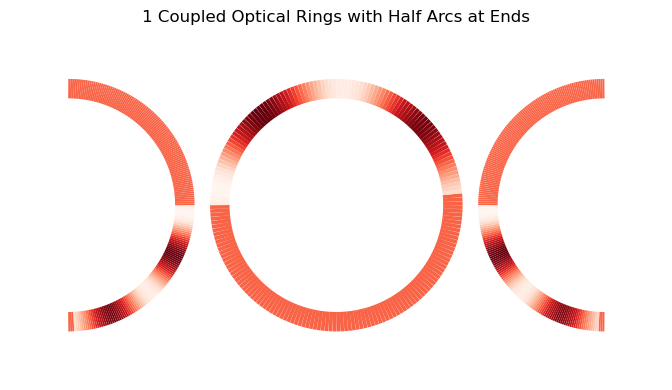

6


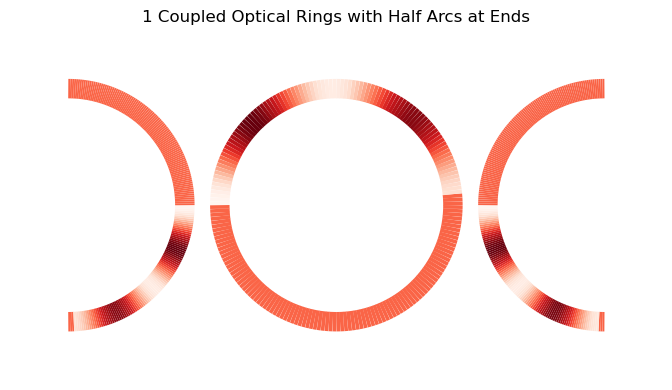

In [ ]:
# Parameters
ez_tab_ordered = np.zeros((N_seg, maxTime, SIZE), dtype = complex)
for ring in range(rings_no):
    if ring%2 == 0: #even segment
        ez_tab_ordered[(2*ring),:,:] = ez_tab[2*ring + 1,:,:]
        ez_tab_ordered[(2*ring)+1,:,:] = ez_tab[2*ring,:,:]
    else:
        ez_tab_ordered[(2*ring),:,:] = ez_tab[2*ring,:,:]
        ez_tab_ordered[(2*ring)+1,:,:] = ez_tab[2*ring + 1,:,:]
        
print(np.shape(ez_tab_ordered))


for tp in range(1000,2000,100):
    ez_tab_tp = ez_tab_ordered[:,tp,:]      
    plot_field_ring(ez_tab_tp, rings_no)

In [ ]:
filenames = ["fft_thru_k2.npz",
             "fft_drop_k2.npz"]
ports = [1, N_seg-2]
for i, ii in zip(filenames, ports):
    data1 = np.load(i)
    freqs1 = data1["freqs"]
    spectrum1 = data1["spectrum"]

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
#while coupling I used different indices so in order for the arc plotting function to stack the electric fields in the order they were coupled, I made this logic.

for ring in range(rings_no):
    if ring%2 ==0:
        print(2*ring, 2*ring +1)
        print(2*ring+1, 2*ring)
    else:
        print(2*ring, 2*ring +1)
        print(2*ring, 2*ring +1)

0 1
1 0
2 3
2 3
4 5
5 4
